# **Travel Insurance Claim Prediction**  

## Target
Target Variable: `Claim` (Binary: Yes/No).  

## Business Context and Objective
This project aims to develop a predictive model to determine whether a travel insurance policyholder will file a claim. The ability to predict claims in advance can help the insurance company better manage financial risk, reduce unexpected payouts, and optimize pricing strategies.  

## Stakeholders 
- **Primary Stakeholder**
    - The **insurance company**
    - maintain profitability by minimizing financial losses from unanticipated claims.  
- **Secondary Stakeholder**
    - The **customers or policyholders**
    - affected by how premiums are priced and whether their claims are fairly processed.  

## Problem Statement
The insurance company currently faces **difficulty in identifying high-risk policies in advance**.  

- **Specific & Measurable Problem**: A small proportion of customers **(~2%)** file claims, but these claims result in significant financial costs. The company lacks a reliable way to **predict which policies** are likely to result in a claim, leading to inefficient pricing and possible loss of revenue.  
    - For example, **false negatives (missed claims)** can cost the company around **$1,000 per case**, while **false positives (wrongly flagged policies)** increase administrative workload and cost around **$50 per case**.

## Why This Problem Matters
- **Specific & Measurable Impact**:  
    - If claims are not predicted accurately, the company risks **high financial losses**, which could affect its long-term sustainability.  
    - Overpricing premiums to cover unknown risks may lead to **customer dissatisfaction or churn**.  
    - **Reduce financial loss** from **false negatives** and processing overhead from **false positives**.
    - Design **fairer pricing strategies**, maintaining competitiveness in the market.

## Project Goal 
- **Specific, Measurable, and Achievable Objective**:  
  Develop a binary classification model that predicts the likelihood of a customer filing a travel insurance claim with a focus on:  
    - **Recall ≥ 60%**: Capturing at least 60% of actual claims to minimize missed payouts.  
    - **F2 Score optimization**: Prioritizing recall while maintaining a reasonable balance with precision.  
    - **Reducing total financial loss** from misclassifications (false negatives and false positives) based on estimated cost metrics.  

This project also aims to provide **actionable insights** to help the business make **data-driven decisions** about pricing, fraud detection, and risk management.


In [ ]:
# Library
import pandas as pd
import numpy as np
from collections import defaultdict
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msn
from IPython.display import display
import plotly.express as px
from collections import Counter as counter # for counting
%matplotlib inline

# Data Splitting
from sklearn.model_selection import train_test_split

# Feature Engineering
from sklearn.compose import ColumnTransformer, make_column_selector # For preprocessing
from sklearn.pipeline import Pipeline # Making pipelines
from imblearn.pipeline import Pipeline as imbpipeline # imbalanced pipelines
from sklearn.preprocessing import StandardScaler, MinMaxScaler # Scale numerical variables
from sklearn.impute import SimpleImputer # Impute missing values
from sklearn.preprocessing import FunctionTransformer # Apply custom functions
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder # Encode categorical variables
from imblearn.over_sampling import SMOTE # For oversampling
from imblearn.under_sampling import RandomUnderSampler # For undersampling
from sklearn.preprocessing import PolynomialFeatures # For polynomial features

# Models
from sklearn.linear_model import LogisticRegression # Logistic Regression
from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn.ensemble import RandomForestClassifier # Random Forest
from imblearn.ensemble import BalancedRandomForestClassifier # imbalanced Random Forest
from sklearn.ensemble import GradientBoostingClassifier # Gradient Boosting
from sklearn.ensemble import StackingClassifier, VotingClassifier # Ensemble methods
from xgboost import XGBClassifier # XGBoost
from lightgbm import LGBMClassifier #LightGBM
from catboost import CatBoostClassifier # CatBoost

# Metrics
from sklearn.metrics import make_scorer, accuracy_score, f1_score, fbeta_score, roc_auc_score, roc_curve, classification_report, average_precision_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold, StratifiedKFold

# XAI
import shap # SHAP values for model interpretability
import joblib # For saving models

# Warning Suppressions
import warnings
warnings.filterwarnings("ignore")


# Data Understanding & Cleaning

In [3]:
df = pd.read_csv('data_travel_insurance.csv')
display(df.info(), df.describe())

# Check missing values and duplicates
print("\nMissing Values:\n", (df.isnull().sum()))
print("\nMissing Values (pct):\n", (df.isnull().sum()/len(df))*100)
print("\nDuplicates:\n", df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44328 entries, 0 to 44327
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                44328 non-null  object 
 1   Agency Type           44328 non-null  object 
 2   Distribution Channel  44328 non-null  object 
 3   Product Name          44328 non-null  object 
 4   Gender                12681 non-null  object 
 5   Duration              44328 non-null  int64  
 6   Destination           44328 non-null  object 
 7   Net Sales             44328 non-null  float64
 8   Commision (in value)  44328 non-null  float64
 9   Age                   44328 non-null  int64  
 10  Claim                 44328 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 3.7+ MB


None

,Duration,Net Sales,Commision (in value),Age
count,44328.000000,44328.000000,44328.000000,44328.000000
mean,49.424292,40.550948,9.707692,39.925600
std,109.153961,48.661970,19.625637,13.954926
min,-1.000000,-357.500000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000
50%,22.000000,26.500000,0.000000,36.000000
75%,53.000000,48.000000,11.550000,43.000000
max,4881.000000,810.000000,283.500000,118.000000



Missing Values:
 Agency                      0
Agency Type                 0
Distribution Channel        0
Product Name                0
Gender                  31647
Duration                    0
Destination                 0
Net Sales                   0
Commision (in value)        0
Age                         0
Claim                       0
dtype: int64

Missing Values (pct):
 Agency                   0.000000
Agency Type              0.000000
Distribution Channel     0.000000
Product Name             0.000000
Gender                  71.392799
Duration                 0.000000
Destination              0.000000
Net Sales                0.000000
Commision (in value)     0.000000
Age                      0.000000
Claim                    0.000000
dtype: float64

Duplicates:
 4667


In [4]:
df.head()

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.0,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.0,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.7,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.0,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.0,28,No


Problems:
- 71% of the gender feature is missing
- -1 and 4881 Duration
- are negative Net Sales justified?
- 118 Age?

## Data Cleaning

In [5]:
# Make a copy for cleaning and feature engineering
df_cleaned = df.copy()

# Drop Gender (71% missing values)
df_cleaned.drop(columns=["Gender"], inplace=True)

### Negative Duration

In [6]:
# Calculate percentage of negative Duration values
negative_duration_pct = df_cleaned[df_cleaned['Duration'] < 0]
print(f"Negative Duration rows: {len(negative_duration_pct)} out of {len(df_cleaned)} ({(len(negative_duration_pct)/len(df_cleaned))*100:.2f}%)")

# Dropping the negative values
df_cleaned = df_cleaned[df_cleaned['Duration'] >= 0]
negative_duration_pct = df_cleaned[df_cleaned['Duration'] < 0]
print(f"Negative Duration rows: {len(negative_duration_pct)} out of {len(df_cleaned)} ({(len(negative_duration_pct)/len(df_cleaned))*100:.2f}%)")

Negative Duration rows: 2 out of 44328 (0.00%)
Negative Duration rows: 0 out of 44326 (0.00%)


### Long Durations

In [7]:
# Filter rows where Duration is greater than 1000 days
long_duration_rows = df_cleaned[df_cleaned['Duration'] > 1000]

# Show count and preview of the first few rows
long_duration_count = len(long_duration_rows)
long_duration_rows_preview = long_duration_rows[['Duration', 'Agency', 'Product Name', 'Net Sales', 'Commision (in value)', 'Claim']].head(15)

display(long_duration_count, long_duration_rows_preview)

13

,Duration,Agency,Product Name,Net Sales,Commision (in value),Claim
87,4736,SSI,Ticket Protector,0.32,0.09,No
4678,4857,SSI,Ticket Protector,0.32,0.09,No
10172,4815,SSI,Ticket Protector,0.32,0.09,No
12140,4652,SSI,Ticket Protector,0.32,0.09,No
19497,4881,SSI,Ticket Protector,0.13,0.04,No
20038,4844,SSI,Ticket Protector,0.32,0.09,No
22215,4580,SSI,Ticket Protector,0.32,0.09,No
25606,4685,SSI,Ticket Protector,0.32,0.09,No
28032,4829,SSI,Ticket Protector,0.32,0.09,No
37207,4609,SSI,Ticket Protector,0.32,0.09,No


In [8]:
# Drop rows with Duration greater than 1000 days as they are likely misinputs
df_cleaned = df_cleaned[df_cleaned['Duration'] <= 1000]

### Negative Net Sales

In [9]:
# Rename "Commision (in value)" to "Commission"
df_cleaned.rename(columns={"Commision (in value)": "Commission"}, inplace=True)

# Convert "Claim" to binary
df_cleaned["Claim"] = df_cleaned["Claim"].map({"Yes": 1, "No": 0})

In [ ]:
# Showing negative Net Sales
neg_sales = df_cleaned[df_cleaned['Net Sales'] < 0]
print(f"Negative Net Sales rows: {len(neg_sales)} out of {len(df_cleaned)} ({(len(neg_sales)/len(df_cleaned))*100:.2f}%)")

print(neg_sales['Net Sales'].sort_values().head())

print(neg_sales['Product Name'].value_counts())
print(neg_sales['Agency'].value_counts())

Negative Net Sales rows: 483 out of 44313 (1.09%)
20137   -357.50
18466   -297.00
36562   -291.75
43350   -289.00
13177   -287.40
Name: Net Sales, dtype: float64
Product Name
Rental Vehicle Excess Insurance      269
Cancellation Plan                     77
2 way Comprehensive Plan              52
Value Plan                            17
Basic Plan                            13
Bronze Plan                           10
Annual Silver Plan                     9
1 way Comprehensive Plan               8
Silver Plan                            7
Premier Plan                           7
24 Protect                             3
Single Trip Travel Protect Silver      2
Ticket Protector                       2
Gold Plan                              2
Single Trip Travel Protect Gold        2
Travel Cruise Protect                  2
Annual Gold Plan                       1
Name: count, dtype: int64
Agency
CWT    269
EPX    137
C2B     29
JZI     19
ADM     11
JWT      5
LWC      4
ART      3
SSI    

In [11]:
neg_sales[['Net Sales', 'Commission']].describe()

,Net Sales,Commission
count,483.000000,483.000000
mean,-60.053437,23.916605
std,50.930810,26.220424
min,-357.500000,0.000000
25%,-78.600000,0.000000
50%,-49.500000,17.820000
75%,-29.700000,35.640000
max,-0.070000,178.200000


Negative values on Net Sales are justified due to claims/refunds made and likely not to be misinputs

### Age

In [12]:
# Show sorted unique ages
print(np.sort(df_cleaned.Age.unique()))

[  0   1   2   3   4   5   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88 118]


The oldest person in the world is 115 y.o. and it seems unlikely to be allowed to travel

In [ ]:
# Limiting age to a reasonable range
df_cleaned = df_cleaned[df_cleaned['Age'] < 118]
print(np.sort(df_cleaned.Age.unique()))

[ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88]


In [14]:
df_cleaned.head()

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commission,Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.0,57,0
1,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,10.0,0.0,33,0
2,JZI,Airlines,Online,Basic Plan,19,INDIA,22.0,7.7,26,0
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,20,UNITED STATES,112.0,0.0,59,0
4,C2B,Airlines,Online,Bronze Plan,8,SINGAPORE,16.0,4.0,28,0


# Feature Engineering (EDA ONLY)
*modelling was done with the following features, but no improvements were observed*

## Age Groups

In [15]:
# Define StatsCanada-based age bins and labels
bins = [0, 15, 25, 65, 130]  # Covering up to age 130
labels = ['Children', 'Youth', 'Adults', 'Seniors']

# Apply binning to create the 'Age Group' column
df_cleaned['Age Group'] = pd.cut(df_cleaned['Age'], bins=bins, labels=labels, right=False)

# Optional: Check the distribution of age groups
print(df_cleaned['Age Group'].value_counts(dropna=False))

# Show updated structure and first few rows
df_cleaned.info(), df_cleaned.head()
df_cleaned.isnull().sum()

Age Group
Adults      40715
Youth        1675
Seniors      1195
Children       54
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 43639 entries, 0 to 44327
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Agency                43639 non-null  object  
 1   Agency Type           43639 non-null  object  
 2   Distribution Channel  43639 non-null  object  
 3   Product Name          43639 non-null  object  
 4   Duration              43639 non-null  int64   
 5   Destination           43639 non-null  object  
 6   Net Sales             43639 non-null  float64 
 7   Commission            43639 non-null  float64 
 8   Age                   43639 non-null  int64   
 9   Claim                 43639 non-null  int64   
 10  Age Group             43639 non-null  category
dtypes: category(1), float64(2), int64(3), object(5)
memory usage: 3.7+ MB


Agency                  0
Agency Type             0
Distribution Channel    0
Product Name            0
Duration                0
Destination             0
Net Sales               0
Commission              0
Age                     0
Claim                   0
Age Group               0
dtype: int64

## Destination's UN GeoScheme Subregion

In [16]:
df_cleaned.Destination.unique()

array(['SINGAPORE', 'MALAYSIA', 'INDIA', 'UNITED STATES',
       'KOREA, REPUBLIC OF', 'THAILAND', 'GERMANY', 'JAPAN', 'INDONESIA',
       'VIET NAM', 'AUSTRALIA', 'FINLAND', 'UNITED KINGDOM', 'SRI LANKA',
       'SPAIN', 'HONG KONG', 'MACAO', 'CHINA', 'UNITED ARAB EMIRATES',
       'IRAN, ISLAMIC REPUBLIC OF', 'TAIWAN, PROVINCE OF CHINA', 'POLAND',
       'CANADA', 'OMAN', 'PHILIPPINES', 'GREECE', 'BELGIUM', 'TURKEY',
       'BRUNEI DARUSSALAM', 'DENMARK', 'SWITZERLAND', 'NETHERLANDS',
       'SWEDEN', 'MYANMAR', 'KENYA', 'CZECH REPUBLIC', 'FRANCE',
       'RUSSIAN FEDERATION', 'PAKISTAN', 'ARGENTINA',
       'TANZANIA, UNITED REPUBLIC OF', 'SERBIA', 'ITALY', 'CROATIA',
       'NEW ZEALAND', 'PERU', 'MONGOLIA', 'CAMBODIA', 'QATAR', 'NORWAY',
       'LUXEMBOURG', 'MALTA', "LAO PEOPLE'S DEMOCRATIC REPUBLIC",
       'ISRAEL', 'SAUDI ARABIA', 'AUSTRIA', 'PORTUGAL', 'NEPAL',
       'UKRAINE', 'ESTONIA', 'ICELAND', 'BRAZIL', 'MEXICO',
       'CAYMAN ISLANDS', 'PANAMA', 'BANGLADESH', 'TURKME

In [17]:
un_subregion_mapping = {
    'SINGAPORE': 'South-eastern Asia',
    'MALAYSIA': 'South-eastern Asia',
    'INDIA': 'Southern Asia',
    'UNITED STATES': 'Northern America',
    'KOREA, REPUBLIC OF': 'Eastern Asia',
    'THAILAND': 'South-eastern Asia',
    'GERMANY': 'Western Europe',
    'JAPAN': 'Eastern Asia',
    'INDONESIA': 'South-eastern Asia',
    'VIET NAM': 'South-eastern Asia',
    'AUSTRALIA': 'Australia and New Zealand',
    'FINLAND': 'Northern Europe',
    'UNITED KINGDOM': 'Northern Europe',
    'SRI LANKA': 'Southern Asia',
    'SPAIN': 'Southern Europe',
    'HONG KONG': 'Eastern Asia',
    'MACAO': 'Eastern Asia',
    'CHINA': 'Eastern Asia',
    'UNITED ARAB EMIRATES': 'Western Asia',
    'IRAN, ISLAMIC REPUBLIC OF': 'Western Asia',
    'TAIWAN, PROVINCE OF CHINA': 'Eastern Asia',
    'POLAND': 'Eastern Europe',
    'CANADA': 'Northern America',
    'OMAN': 'Western Asia',
    'PHILIPPINES': 'South-eastern Asia',
    'GREECE': 'Southern Europe',
    'BELGIUM': 'Western Europe',
    'TURKEY': 'Western Asia',
    'BRUNEI DARUSSALAM': 'South-eastern Asia',
    'DENMARK': 'Northern Europe',
    'SWITZERLAND': 'Western Europe',
    'NETHERLANDS': 'Western Europe',
    'SWEDEN': 'Northern Europe',
    'MYANMAR': 'South-eastern Asia',
    'KENYA': 'Eastern Africa',
    'CZECH REPUBLIC': 'Eastern Europe',
    'FRANCE': 'Western Europe',
    'RUSSIAN FEDERATION': 'Eastern Europe',
    'PAKISTAN': 'Southern Asia',
    'ARGENTINA': 'South America',
    'TANZANIA, UNITED REPUBLIC OF': 'Eastern Africa',
    'SERBIA': 'Southern Europe',
    'ITALY': 'Southern Europe',
    'CROATIA': 'Southern Europe',
    'NEW ZEALAND': 'Australia and New Zealand',
    'PERU': 'South America',
    'MONGOLIA': 'Eastern Asia',
    'CAMBODIA': 'South-eastern Asia',
    'QATAR': 'Western Asia',
    'NORWAY': 'Northern Europe',
    'LUXEMBOURG': 'Western Europe',
    'MALTA': 'Southern Europe',
    "LAO PEOPLE'S DEMOCRATIC REPUBLIC": 'South-eastern Asia',
    'ISRAEL': 'Western Asia',
    'SAUDI ARABIA': 'Western Asia',
    'AUSTRIA': 'Western Europe',
    'PORTUGAL': 'Southern Europe',
    'NEPAL': 'Southern Asia',
    'UKRAINE': 'Eastern Europe',
    'ESTONIA': 'Northern Europe',
    'ICELAND': 'Northern Europe',
    'BRAZIL': 'South America',
    'MEXICO': 'Central America',
    'CAYMAN ISLANDS': 'Caribbean',
    'PANAMA': 'Central America',
    'BANGLADESH': 'Southern Asia',
    'TURKMENISTAN': 'Central Asia',
    'BAHRAIN': 'Western Asia',
    'KAZAKHSTAN': 'Central Asia',
    'TUNISIA': 'Northern Africa',
    'IRELAND': 'Northern Europe',
    'ETHIOPIA': 'Eastern Africa',
    'NORTHERN MARIANA ISLANDS': 'Micronesia',
    'MALDIVES': 'Southern Asia',
    'SOUTH AFRICA': 'Southern Africa',
    'VENEZUELA': 'South America',
    'COSTA RICA': 'Central America',
    'JORDAN': 'Western Asia',
    'MALI': 'Western Africa',
    'CYPRUS': 'Western Asia',
    'MAURITIUS': 'Eastern Africa',
    'LEBANON': 'Western Asia',
    'KUWAIT': 'Western Asia',
    'AZERBAIJAN': 'Western Asia',
    'HUNGARY': 'Eastern Europe',
    'BHUTAN': 'Southern Asia',
    'BELARUS': 'Eastern Europe',
    'MOROCCO': 'Northern Africa',
    'ECUADOR': 'South America',
    'UZBEKISTAN': 'Central Asia',
    'CHILE': 'South America',
    'FIJI': 'Melanesia',
    'PAPUA NEW GUINEA': 'Melanesia',
    'ANGOLA': 'Middle Africa',
    'FRENCH POLYNESIA': 'Polynesia',
    'NIGERIA': 'Western Africa',
    'MACEDONIA, THE FORMER YUGOSLAV REPUBLIC OF': 'Southern Europe',
    'NAMIBIA': 'Southern Africa',
    'GEORGIA': 'Western Asia',
    'COLOMBIA': 'South America',
    'SLOVENIA': 'Southern Europe',
    'EGYPT': 'Northern Africa',
    'ZIMBABWE': 'Eastern Africa',
    'BULGARIA': 'Eastern Europe',
    'BERMUDA': 'Caribbean',
    'URUGUAY': 'South America',
    'GUINEA': 'Western Africa',
    'GHANA': 'Western Africa',
    'BOLIVIA': 'South America',
    'TRINIDAD AND TOBAGO': 'Caribbean',
    'VANUATU': 'Melanesia',
    'GUAM': 'Micronesia',
    'UGANDA': 'Eastern Africa',
    'JAMAICA': 'Caribbean',
    'LATVIA': 'Northern Europe',
    'ROMANIA': 'Eastern Europe',
    'REPUBLIC OF MONTENEGRO': 'Southern Europe',
    'KYRGYZSTAN': 'Central Asia',
    'GUADELOUPE': 'Caribbean',
    'ZAMBIA': 'Eastern Africa',
    'RWANDA': 'Eastern Africa',
    'BOTSWANA': 'Southern Africa',
    'GUYANA': 'South America',
    'LITHUANIA': 'Northern Europe',
    'GUINEA-BISSAU': 'Western Africa',
    'SENEGAL': 'Western Africa',
    'CAMEROON': 'Middle Africa',
    'TIBET': 'Southern Asia',  # disputed/undefined
    'SAMOA': 'Polynesia',
    'PUERTO RICO': 'Caribbean',
    'TAJIKISTAN': 'Central Asia',
    'ARMENIA': 'Western Asia',
    'FAROE ISLANDS': 'Northern Europe',
    'DOMINICAN REPUBLIC': 'Caribbean',
    'MOLDOVA, REPUBLIC OF': 'Eastern Europe',
    'BENIN': 'Western Africa',
    'REUNION': 'Eastern Africa',
    "KOREA, DEMOCRATIC PEOPLE'S REPUBLIC OF": 'Eastern Asia'
}

# Map the UN subregions to the 'Destination' column
df_cleaned['UN_subregion'] = df_cleaned['Destination'].map(un_subregion_mapping)

# Check for unmapped countries
unmapped = df_cleaned[df_cleaned['UN_subregion'].isna()]['Destination'].unique()
print("Unmapped countries:", unmapped)

Unmapped countries: []


## Duration Groups

In [18]:
df_cleaned.Duration.unique()

array([365,   4,  19,  20,   8,   2,  25,  90,  24,  43, 103, 376,   6,
        16,  27,  34,   3,  14,  12,  31,   5,   7,  56,  29,  30,  58,
         9,  38,  42,  11,  13,  40,  79, 370, 366,  26,  83,  55,  18,
       100,   1,  35,  36,  75,  23,  73,  32, 232,  37,  10,  15,  17,
        99, 173,  74,  82,  66, 156,  39,  95,  98, 111, 430,  53,  77,
        87,  70, 151,  45,  54, 114, 118,  62,  28, 112, 326,  22,  59,
        44,  21,  97,  63,  60,  51, 180, 160, 368,  65,  93,  71,  57,
         0,  76,  69, 110, 146, 116, 129,  84,  33, 149,  68,  64, 101,
       145,  88, 222, 176, 165, 169, 387,  49, 109,  41, 381,  50, 161,
       154, 330,  46,  78,  47, 121, 106, 140,  91, 104, 134, 393, 282,
       123, 172,  86, 102, 314, 386, 383,  81, 283, 115, 144,  61, 206,
       213, 271, 174, 152, 122,  94, 215, 228, 108, 124,  48, 159, 135,
       179, 369, 372, 150, 107,  85, 142,  52, 137,  80, 278,  92,  89,
       276, 226, 373, 113, 132, 187, 120, 158, 171, 183, 379, 16

Grouping Duration based on its total length of days might be a great idea

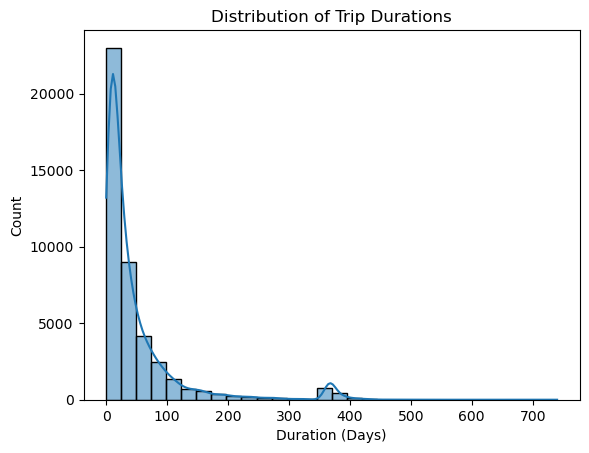

In [19]:
sns.histplot(df_cleaned['Duration'], bins=30, kde=True)
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (Days)')
plt.show()

In [20]:
bins = [0, 3, 7, 14, 30, 90, 365, np.inf]
labels = [
    '0-3 days (Short Weekend)', 
    '4-7 days (Week-long)', 
    '8-14 days (Two Weeks)', 
    '15-30 days (Month)', 
    '31-90 days (Quarter)', 
    '91-365 days (Annual)', 
    '366+ days (Long-term)'
]

df_cleaned['Duration Group'] = pd.cut(
    df_cleaned['Duration'], 
    bins=bins, 
    labels=labels, 
    right=False  # Includes the left edge, excludes the right
)

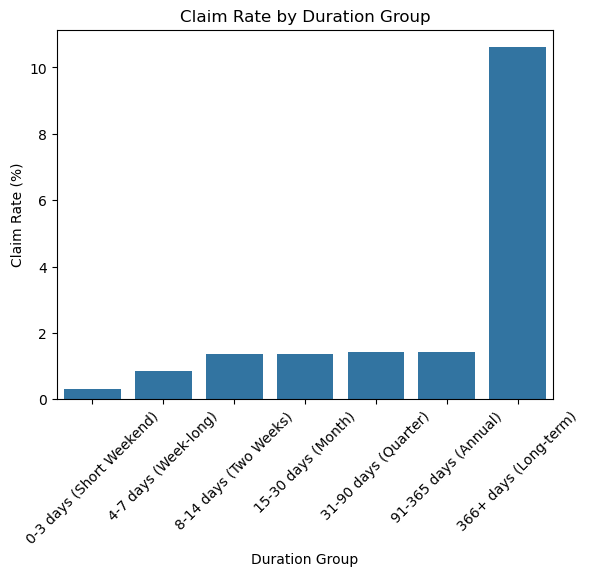

In [21]:
# Calculate claim rate per duration group
claim_rate = df_cleaned.groupby('Duration Group')['Claim'].mean() * 100

# Visualize
sns.barplot(x=claim_rate.index, y=claim_rate.values)
plt.title('Claim Rate by Duration Group')
plt.ylabel('Claim Rate (%)')
plt.xticks(rotation=45)
plt.show()

## Plan Tier

In [22]:
display(df_cleaned['Product Name'].value_counts(),
df_cleaned['Product Name'].unique())

Product Name
Cancellation Plan                       12977
2 way Comprehensive Plan                 9317
Rental Vehicle Excess Insurance          5979
Basic Plan                               3794
Bronze Plan                              2847
1 way Comprehensive Plan                 2333
Silver Plan                              1552
Value Plan                               1341
Annual Silver Plan                        975
Ticket Protector                          742
Travel Cruise Protect                     353
Gold Plan                                 237
Comprehensive Plan                        226
24 Protect                                171
Annual Gold Plan                          142
Single Trip Travel Protect Gold           135
Premier Plan                              128
Single Trip Travel Protect Silver         117
Annual Travel Protect Gold                 63
Annual Travel Protect Silver               59
Individual Comprehensive Plan              48
Single Trip Travel Pr

array(['Annual Silver Plan', 'Cancellation Plan', 'Basic Plan',
       '2 way Comprehensive Plan', 'Bronze Plan',
       '1 way Comprehensive Plan', 'Rental Vehicle Excess Insurance',
       'Single Trip Travel Protect Gold', 'Silver Plan', 'Value Plan',
       '24 Protect', 'Annual Travel Protect Gold', 'Comprehensive Plan',
       'Ticket Protector', 'Travel Cruise Protect',
       'Single Trip Travel Protect Silver',
       'Individual Comprehensive Plan', 'Gold Plan', 'Annual Gold Plan',
       'Child Comprehensive Plan', 'Premier Plan',
       'Annual Travel Protect Silver',
       'Single Trip Travel Protect Platinum',
       'Annual Travel Protect Platinum',
       'Spouse or Parents Comprehensive Plan',
       'Travel Cruise Protect Family'], dtype=object)

Product name is high cardinal data, but in essence are divided into four groups:
1. Cancellation & Excess (cancellation plan, rental vehicle excess plan)
2. Basic (basic, bronze, Value, ticket protector, travel cruise protect)
3. Silver (Silver)
4. Premium(Gold, platinum, Comprehensive, premier, 24 protect)

In [23]:
# Map product names to tiers
tier_mapping = {
    # Cancellation & Excess Tier
    'Cancellation Plan': 'Cancellation & Excess',
    'Rental Vehicle Excess Insurance': 'Cancellation & Excess',
    
    # Basic Tier
    'Basic Plan': 'Basic',
    'Bronze Plan': 'Basic',
    'Value Plan': 'Basic',
    'Ticket Protector': 'Basic',
    'Travel Cruise Protect': 'Basic',
    'Travel Cruise Protect Family': 'Basic',
    
    # Silver Tier
    'Annual Silver Plan': 'Silver',
    'Silver Plan': 'Silver',
    'Single Trip Travel Protect Silver': 'Silver',
    'Annual Travel Protect Silver': 'Silver',
    
    # Premium Tier
    '2 way Comprehensive Plan': 'Premium',
    '1 way Comprehensive Plan': 'Premium',
    '24 Protect': 'Premium',
    'Comprehensive Plan': 'Premium',
    'Gold Plan': 'Premium',
    'Annual Gold Plan': 'Premium',
    'Premier Plan': 'Premium',
    'Single Trip Travel Protect Gold': 'Premium',
    'Annual Travel Protect Gold': 'Premium',
    'Single Trip Travel Protect Platinum': 'Premium',
    'Annual Travel Protect Platinum': 'Premium',
    'Individual Comprehensive Plan': 'Premium',
    'Child Comprehensive Plan': 'Premium',
    'Spouse or Parents Comprehensive Plan': 'Premium'
}

# Map product names to tiers
df_cleaned['Tier'] = df_cleaned['Product Name'].map(tier_mapping)
print(df_cleaned['Tier'].value_counts())

Tier
Cancellation & Excess    18956
Premium                  12902
Basic                     9078
Silver                    2703
Name: count, dtype: int64


In [24]:
display(df_cleaned.head(), df_cleaned.info(), df_cleaned.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 43639 entries, 0 to 44327
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Agency                43639 non-null  object  
 1   Agency Type           43639 non-null  object  
 2   Distribution Channel  43639 non-null  object  
 3   Product Name          43639 non-null  object  
 4   Duration              43639 non-null  int64   
 5   Destination           43639 non-null  object  
 6   Net Sales             43639 non-null  float64 
 7   Commission            43639 non-null  float64 
 8   Age                   43639 non-null  int64   
 9   Claim                 43639 non-null  int64   
 10  Age Group             43639 non-null  category
 11  UN_subregion          43639 non-null  object  
 12  Duration Group        43639 non-null  category
 13  Tier                  43639 non-null  object  
dtypes: category(2), float64(2), int64(3), object(7)
memory usag

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commission,Age,Claim,Age Group,UN_subregion,Duration Group,Tier
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.0,57,0,Adults,South-eastern Asia,366+ days (Long-term),Silver
1,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,10.0,0.0,33,0,Adults,South-eastern Asia,4-7 days (Week-long),Cancellation & Excess
2,JZI,Airlines,Online,Basic Plan,19,INDIA,22.0,7.7,26,0,Adults,Southern Asia,15-30 days (Month),Basic
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,20,UNITED STATES,112.0,0.0,59,0,Adults,Northern America,15-30 days (Month),Premium
4,C2B,Airlines,Online,Bronze Plan,8,SINGAPORE,16.0,4.0,28,0,Adults,South-eastern Asia,8-14 days (Two Weeks),Basic


None

,Duration,Net Sales,Commission,Age,Claim
count,43639.000000,43639.000000,43639.000000,43639.000000,43639.000000
mean,48.331584,40.418342,9.560861,38.713765,0.015353
std,73.811983,48.650513,19.610834,10.094507,0.122955
min,0.000000,-357.500000,0.000000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000,0.000000
50%,22.000000,26.000000,0.000000,36.000000,0.000000
75%,53.000000,48.000000,10.500000,42.000000,0.000000
max,740.000000,682.000000,262.760000,88.000000,1.000000


# EDA

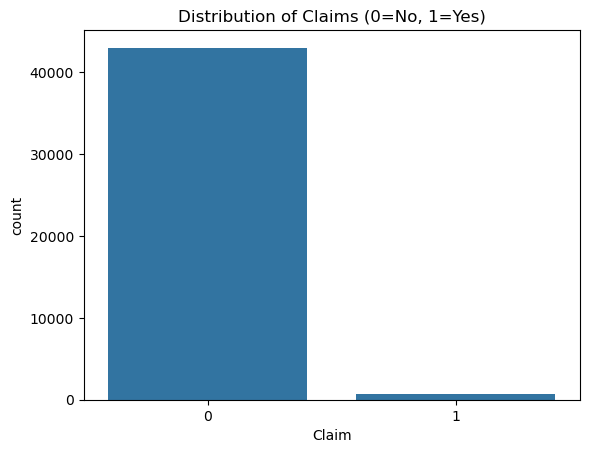

Claim Rate: 1.54%


In [25]:
# Class distribution of target variable
sns.countplot(data=df_cleaned, x='Claim')
plt.title('Distribution of Claims (0=No, 1=Yes)')
plt.show()

# Claim rate
claim_rate = df_cleaned['Claim'].mean() * 100
print(f"Claim Rate: {claim_rate:.2f}%")

The dataset is imbalanced

## Categorical
### Based on Total Count of Claims

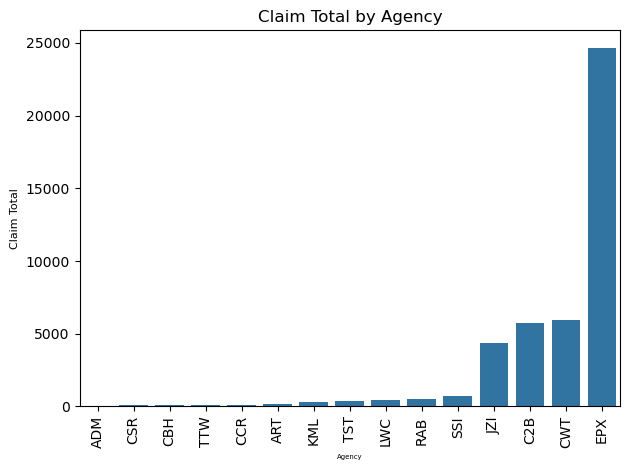

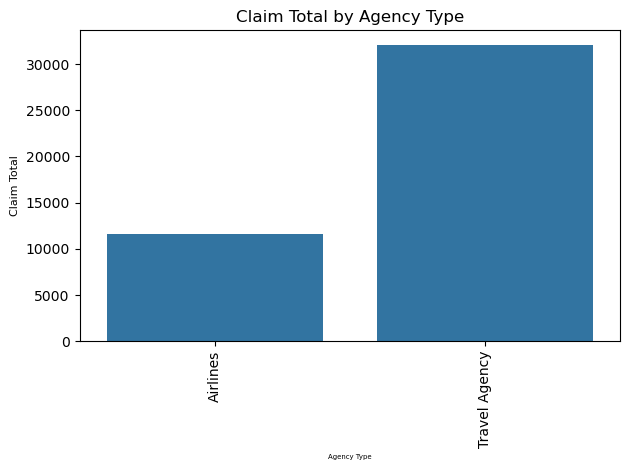

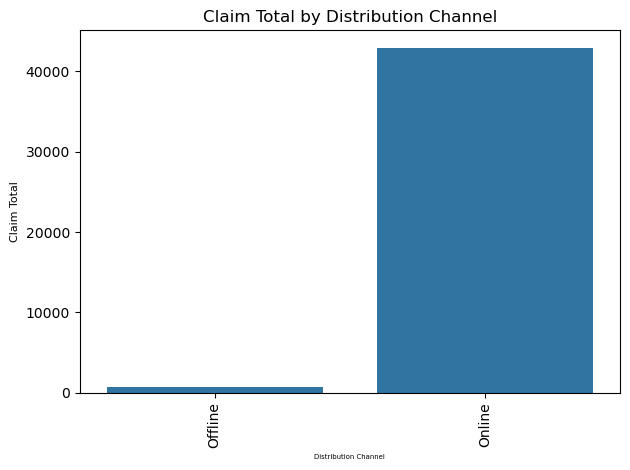

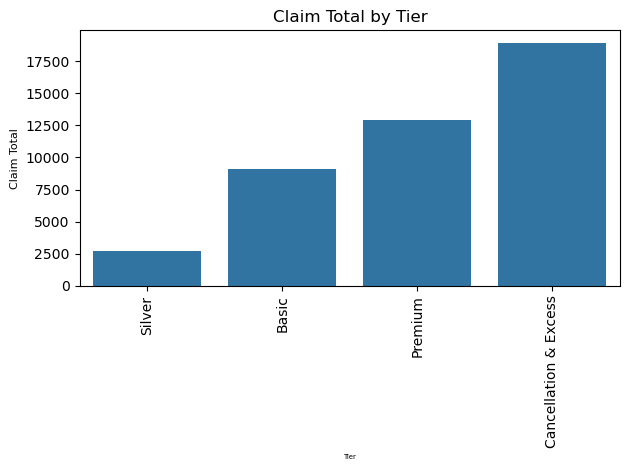

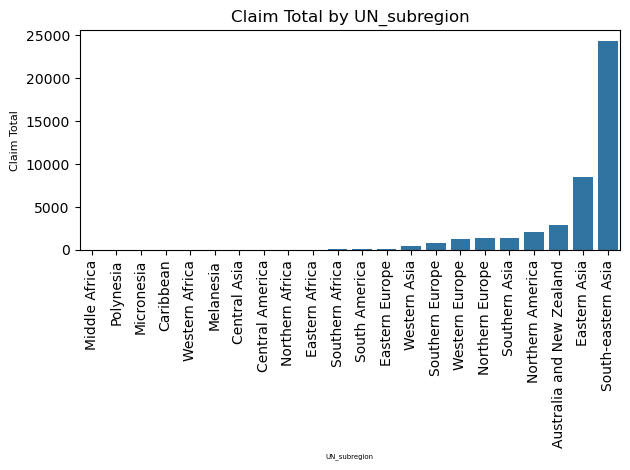

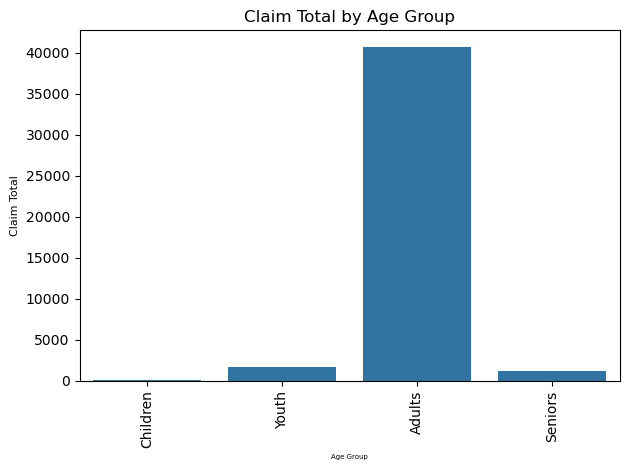

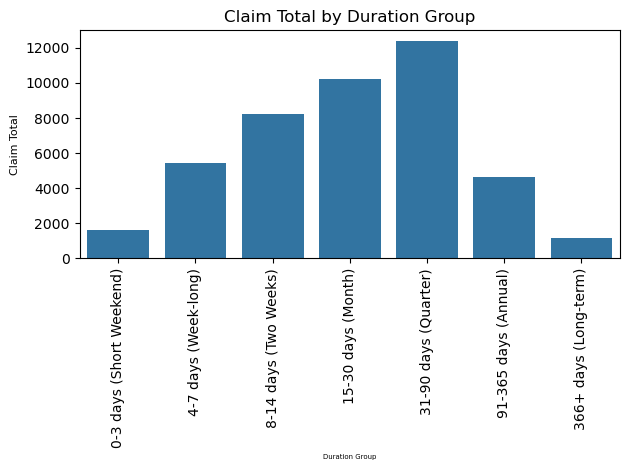

In [26]:
def plot_claim(categorical_col):
    claim_total = df_cleaned.groupby(categorical_col)['Claim'].count().sort_values()
    sns.barplot(x=claim_total.index, y=claim_total.values)
    plt.title(f'Claim Total by {categorical_col}')
    plt.xlabel(categorical_col, fontsize=5)
    plt.ylabel('Claim Total', fontsize=8)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Example: Agency Type
plot_claim('Agency')
plot_claim('Agency Type')
plot_claim('Distribution Channel')
plot_claim('Tier')
plot_claim('UN_subregion')
plot_claim('Age Group')
plot_claim('Duration Group')

### Based on Proportion of Claims

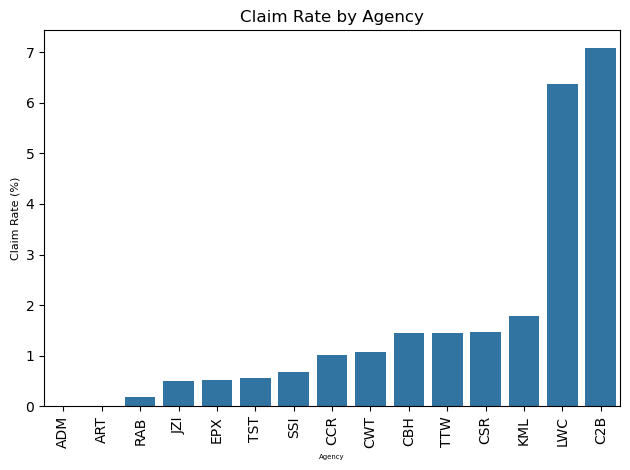

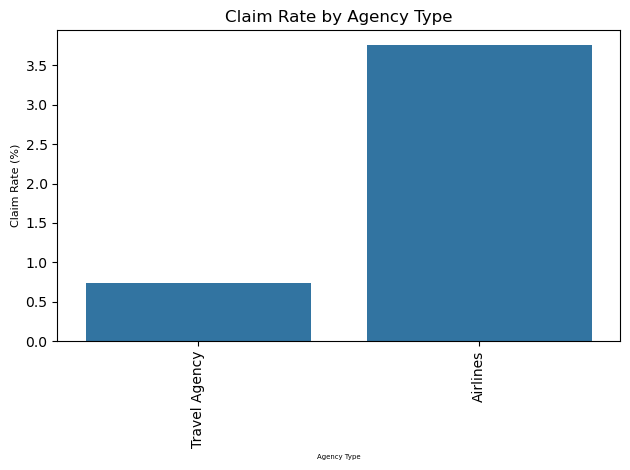

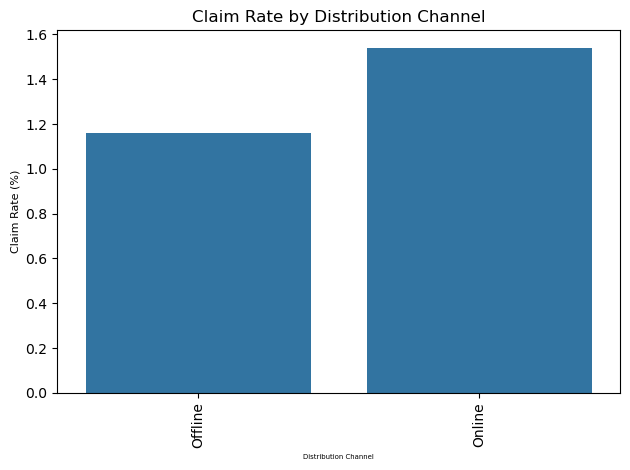

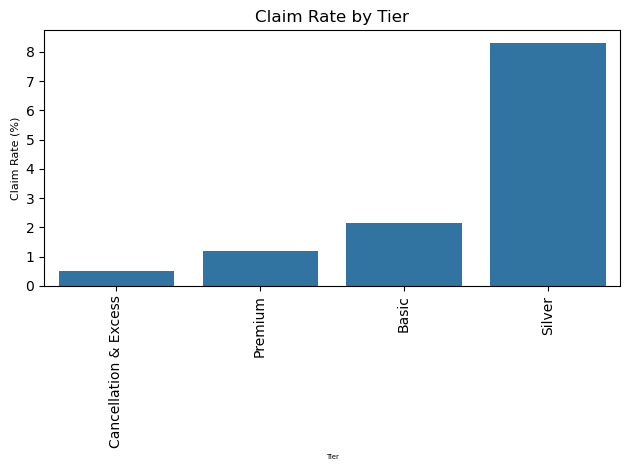

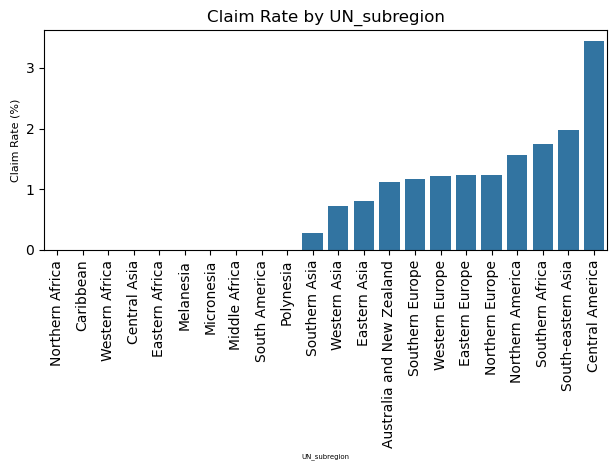

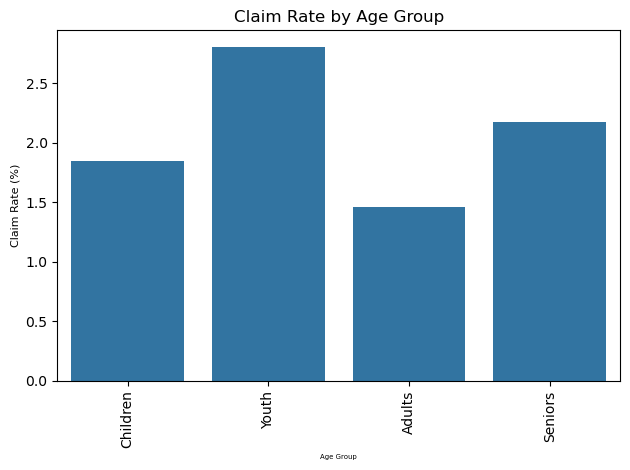

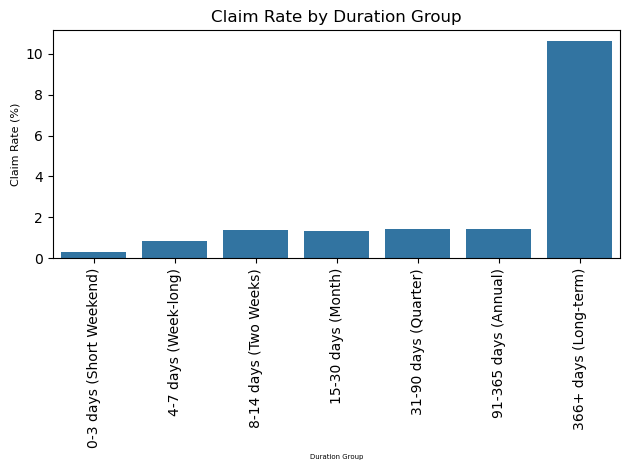

In [27]:
def plot_claim_rate(categorical_col):
    claim_rate = df_cleaned.groupby(categorical_col)['Claim'].mean().sort_values() * 100
    sns.barplot(x=claim_rate.index, y=claim_rate.values)
    plt.title(f'Claim Rate by {categorical_col}')
    plt.xlabel(categorical_col, fontsize=5)
    plt.ylabel('Claim Rate (%)', fontsize=8)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# plotting claim rates for various categorical columns
plot_claim_rate('Agency')
plot_claim_rate('Agency Type')
plot_claim_rate('Distribution Channel')
plot_claim_rate('Tier')
plot_claim_rate('UN_subregion')
plot_claim_rate('Age Group')
plot_claim_rate('Duration Group')

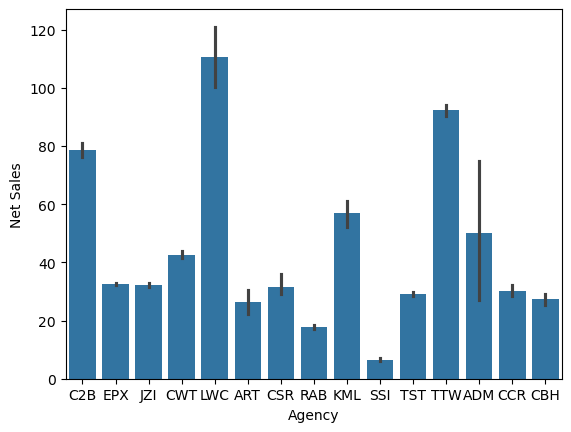

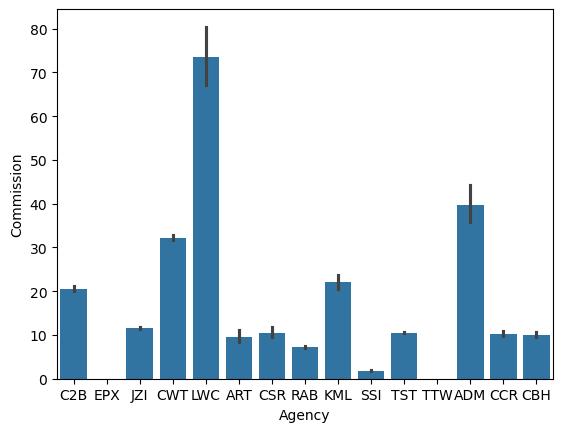

In [28]:
sns.barplot(data=df_cleaned, x='Agency', y='Net Sales')
plt.show()
sns.barplot(data=df_cleaned, x='Agency', y='Commission')
plt.show()

We can see some signs of contrast between features and variables to our label, especially agency, destination, and duration

## Numeric

In [29]:
df_cleaned.describe()

,Duration,Net Sales,Commission,Age,Claim
count,43639.000000,43639.000000,43639.000000,43639.000000,43639.000000
mean,48.331584,40.418342,9.560861,38.713765,0.015353
std,73.811983,48.650513,19.610834,10.094507,0.122955
min,0.000000,-357.500000,0.000000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000,0.000000
50%,22.000000,26.000000,0.000000,36.000000,0.000000
75%,53.000000,48.000000,10.500000,42.000000,0.000000
max,740.000000,682.000000,262.760000,88.000000,1.000000


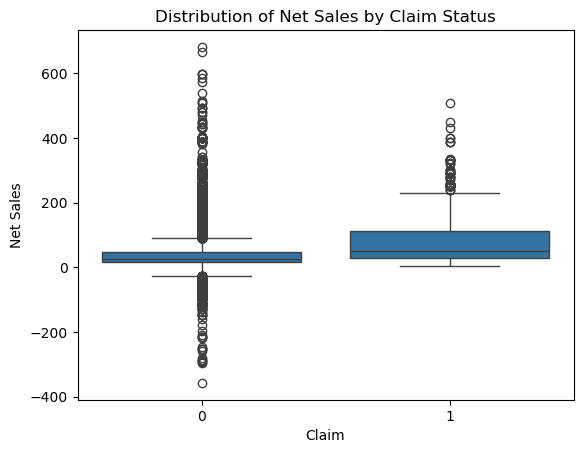

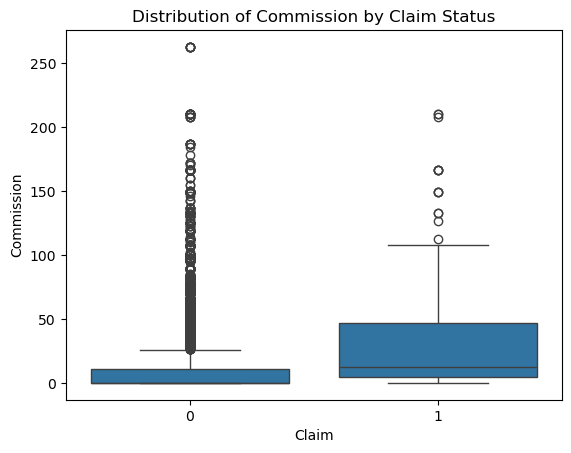

In [30]:
def plot_numerical_distribution(numerical_col):
    sns.boxplot(data=df_cleaned, x='Claim', y=numerical_col)
    plt.title(f'Distribution of {numerical_col} by Claim Status')
    plt.show()

# Check these columns:
plot_numerical_distribution('Net Sales')
plot_numerical_distribution('Commission')

## Correlations

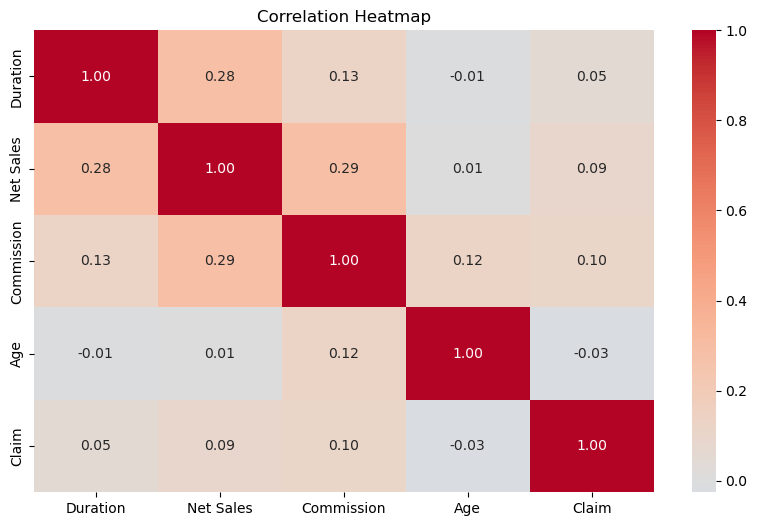

In [31]:
# correlation heatmap of features and target variable
plt.figure(figsize=(10, 6))

# Select only numeric columns for correlation
numeric_columns = df_cleaned.select_dtypes(include=['number'])
correlation_matrix = numeric_columns.corr(method='spearman')

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

No high correlation between variables were found

# Modelling

In [32]:
display(df_cleaned.info(), df_cleaned.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 43639 entries, 0 to 44327
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Agency                43639 non-null  object  
 1   Agency Type           43639 non-null  object  
 2   Distribution Channel  43639 non-null  object  
 3   Product Name          43639 non-null  object  
 4   Duration              43639 non-null  int64   
 5   Destination           43639 non-null  object  
 6   Net Sales             43639 non-null  float64 
 7   Commission            43639 non-null  float64 
 8   Age                   43639 non-null  int64   
 9   Claim                 43639 non-null  int64   
 10  Age Group             43639 non-null  category
 11  UN_subregion          43639 non-null  object  
 12  Duration Group        43639 non-null  category
 13  Tier                  43639 non-null  object  
dtypes: category(2), float64(2), int64(3), object(7)
memory usag

None

,Duration,Net Sales,Commission,Age,Claim
count,43639.000000,43639.000000,43639.000000,43639.000000,43639.000000
mean,48.331584,40.418342,9.560861,38.713765,0.015353
std,73.811983,48.650513,19.610834,10.094507,0.122955
min,0.000000,-357.500000,0.000000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000,0.000000
50%,22.000000,26.000000,0.000000,36.000000,0.000000
75%,53.000000,48.000000,10.500000,42.000000,0.000000
max,740.000000,682.000000,262.760000,88.000000,1.000000


In [33]:
display(df_cleaned.describe(), df_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
Index: 43639 entries, 0 to 44327
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Agency                43639 non-null  object  
 1   Agency Type           43639 non-null  object  
 2   Distribution Channel  43639 non-null  object  
 3   Product Name          43639 non-null  object  
 4   Duration              43639 non-null  int64   
 5   Destination           43639 non-null  object  
 6   Net Sales             43639 non-null  float64 
 7   Commission            43639 non-null  float64 
 8   Age                   43639 non-null  int64   
 9   Claim                 43639 non-null  int64   
 10  Age Group             43639 non-null  category
 11  UN_subregion          43639 non-null  object  
 12  Duration Group        43639 non-null  category
 13  Tier                  43639 non-null  object  
dtypes: category(2), float64(2), int64(3), object(7)
memory usag

,Duration,Net Sales,Commission,Age,Claim
count,43639.000000,43639.000000,43639.000000,43639.000000,43639.000000
mean,48.331584,40.418342,9.560861,38.713765,0.015353
std,73.811983,48.650513,19.610834,10.094507,0.122955
min,0.000000,-357.500000,0.000000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000,0.000000
50%,22.000000,26.000000,0.000000,36.000000,0.000000
75%,53.000000,48.000000,10.500000,42.000000,0.000000
max,740.000000,682.000000,262.760000,88.000000,1.000000


None

## Defining Features & Target

In [34]:
# Define categorical and numerical columns
cat_cols = ['Product Name', 'Agency', 'Destination', 'Distribution Channel']
num_cols = ['Age', 'Duration', 'Commission', 'Net Sales']

# or
# cat_cols = make_column_selector(dtype_include='object')
# num_cols = make_column_selector(dtype_exclude='object')

features = cat_cols + num_cols

X = df_cleaned[features]
y = df_cleaned['Claim']

# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [35]:
from statsmodels.api import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select only numeric columns for VIF calculation
X_numeric = X.select_dtypes(include=[np.number])

# Add constant for intercept
X_numeric = add_constant(X_numeric)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]

print(vif_data)


      Feature        VIF
0       const  16.509319
1         Age   1.013944
2    Duration   1.613655
3  Commission   1.770313
4   Net Sales   2.113488


VIF was done to make sure there are no multicollinearity

Our model must perform better than the naive models

## Preprocessor

In [36]:
poly = PolynomialFeatures(degree=2, include_bias=False) # for LogRegression. tree-based models do not benefit from Polynomial Features, already model non-linearities

preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')), # NAs imputer
        ('poly', poly), # polynomial
        ('scaler', StandardScaler()) # numerical scaler
    ]), num_cols),
    
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols) # categorical encoder to numerical
])

In [37]:
def get_preprocessor(model_name): # for different models without the need for polynomial and scaling
    if model_name in ['DecisionTree', 'RandomForest', 'LGBM', 'BalancedRF', 'XGBoost', 'CatBoost']:
        return ColumnTransformer([
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
            ('num', SimpleImputer(strategy='median'), num_cols)
        ])
    else:
        return preprocessor  

## Metrics

In [38]:
scorers = {
    'precision': 'precision', # proportion of true positives out of all predicted positives
    'recall': 'recall', # proportion of true positives out of all actual positives
    'f1': 'f1', # harmonic mean of precision and recall
    'f2': make_scorer(fbeta_score, beta=2), # f1 but more weight on recall for imbalanced datasets
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True), # recall vs false positive rate
    'pr_auc': make_scorer(average_precision_score, needs_proba=True) # precision vs recall
}

## Baseline Naive Model

In [39]:
# Define baseline predictions: always predict class 0
baseline_pred = [0] * len(y_test)

# Evaluate baseline
print("Accuracy:", accuracy_score(y_test, baseline_pred))
print("\nClassification Report:")
print(classification_report(y_test, baseline_pred))
print("Precision-Recall AUC:", average_precision_score(y_test, baseline_pred))
print("ROC AUC Score:", roc_auc_score(y_test, baseline_pred))
print("Precision-Recall AUC:", average_precision_score(y_test, baseline_pred))
print("F2 Score:", fbeta_score(y_test, baseline_pred, beta=2))

# Plot confusion matrix
cm = confusion_matrix(y_test, baseline_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Claim", "Claim"])
disp.plot(cmap=plt.cm.Blues)

Accuracy: 0.9846471127406049

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8594
           1       0.00      0.00      0.00       134

    accuracy                           0.98      8728
   macro avg       0.49      0.50      0.50      8728
weighted avg       0.97      0.98      0.98      8728

Precision-Recall AUC: 0.01535288725939505
ROC AUC Score: 0.5
Precision-Recall AUC: 0.01535288725939505
F2 Score: 0.0


## Models

In [52]:
# Optimized model dictionary for imbalanced classification
models = {
    'LogReg': {
        'model': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
        'params': {
            'classifier__penalty': ['l1', 'l2'],
            'classifier__C': [0.01, 0.1, 1, 10],
            'classifier__solver': ['liblinear'] 
        }
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(class_weight='balanced', random_state=42),
        'params': {
            'classifier__max_depth': [3, 5, 7, None],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__criterion': ['gini', 'entropy']
        }
    },
    'BalancedRF': {
        'model': BalancedRandomForestClassifier(random_state=42),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [None, 5, 10],
            'classifier__min_samples_split': [2, 5],
            'classifier__sampling_strategy': ['auto', 0.5, 1.0]  # Controls how much to oversample minority
        }
    },
    'LGBM': {
        'model': LGBMClassifier(random_state=42, verbose=-1),
        'params': {
            'classifier__learning_rate': [0.01, 0.05, 0.1],
            'classifier__num_leaves': [31, 63],
            'classifier__reg_alpha': [0, 0.1, 0.5],
            'classifier__reg_lambda': [0, 0.1, 0.5],
            'classifier__scale_pos_weight': [1, 10, 25]  # Important for imbalance
        }
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'params': {
            'classifier__learning_rate': [0.01, 0.05, 0.1],
            'classifier__max_depth': [3, 5, 7],
            'classifier__gamma': [0, 0.1, 0.2],
            'classifier__reg_alpha': [0, 0.1, 0.5],
            'classifier__reg_lambda': [0, 0.1, 0.5],
            'classifier__scale_pos_weight': [1, 10, 25]
        }
    },
    'CatBoost': {
        'model': CatBoostClassifier(verbose=0, random_state=42),
        'params': {
            'classifier__learning_rate': [0.01, 0.05, 0.1],
            'classifier__depth': [4, 6, 8],
            'classifier__l2_leaf_reg': [1, 3, 5],
            'classifier__auto_class_weights': ['None', 'Balanced']
        }
    }
}

In [ ]:
# --- Setup ---
FN_COST = 1000
FP_COST = 50
f2_scorer = make_scorer(fbeta_score, beta=2)

# Make sure save folder exists
os.makedirs("saved_models", exist_ok=True)

# --- Storage ---
best_models_nogrid = {}
best_models_f2 = {}
best_models_recall = {}

results_nogrid = {}
results_f2 = {}
results_recall = {}

## Ensemble

*Ensemble methods took 355 minutes to run, making them computationally expensive and inefficient (Recall <0.32)*


In [ ]:
# More diverse base estimators
# base_estimators = [
#    ('logreg', LogisticRegression(class_weight='balanced')),
#    ('lgbm', LGBMClassifier(is_unbalance=True)),
#    ('brf', BalancedRandomForestClassifier(n_estimators=100)),
#    ('catboost', CatBoostClassifier(verbose=0, random_state=42))
#]

# Use Random Forest as meta-estimator to improve generalization
# meta_estimator = RandomForestClassifier(class_weight='balanced')

# Improved stacking classifier
#stacking_clf = StackingClassifier(
#    estimators=base_estimators,
#    final_estimator=meta_estimator,
#    passthrough=True
#)

# Soft Voting Classifier
#voting_clf = VotingClassifier(
#    estimators=base_estimators,
#    voting='soft'
#)

# Add to your models dictionary
#models['Stacking_Improved'] = {
#    'model': stacking_clf,
#    'params': {
#        'classifier__final_estimator__n_estimators': [50, 100],
#        'classifier__final_estimator__max_depth': [3, 5],
#        'classifier__lgbm__num_leaves': [31, 63],
#        'classifier__brf__max_depth': [5, None]
#    }
#}

#models['Voting_Improved'] = {
#    'model': voting_clf,
#    'params': {}
#}

# Results

## No Gridsearch (Default Baseline)

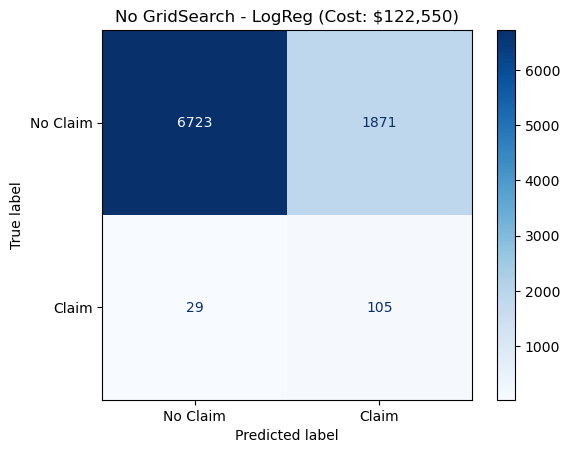

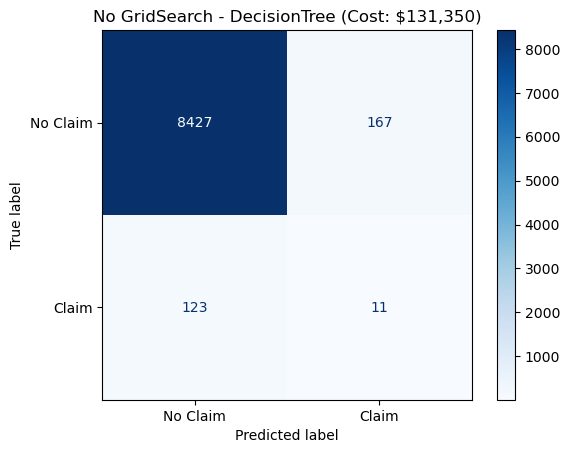

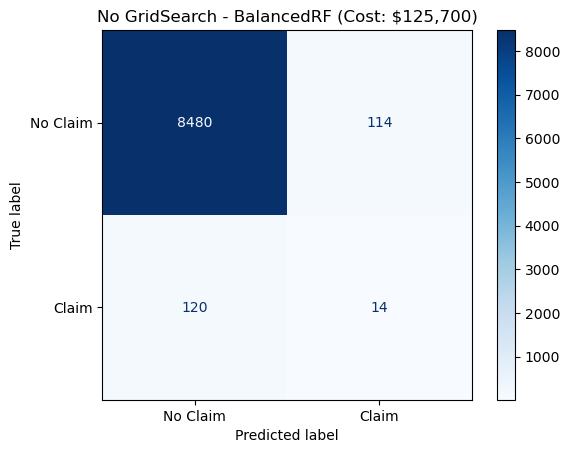

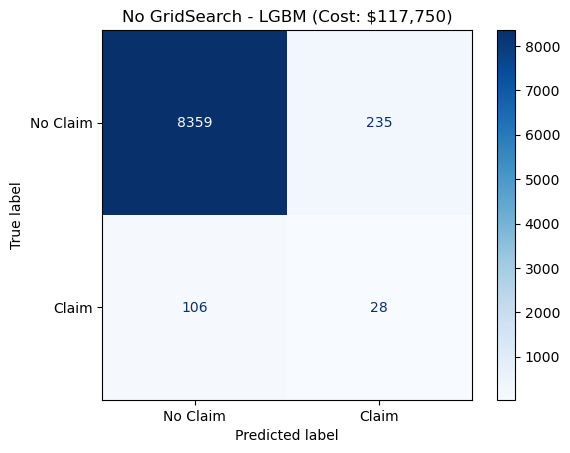

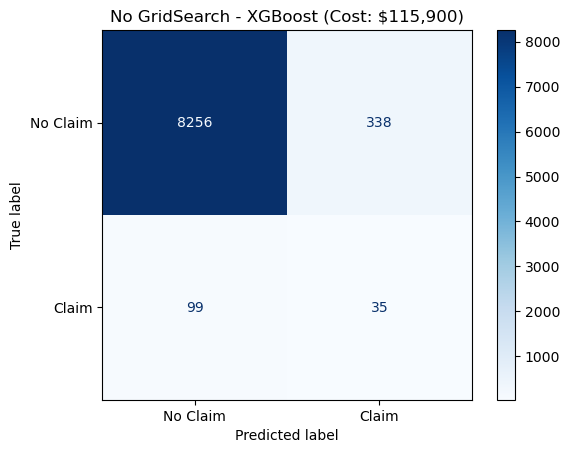

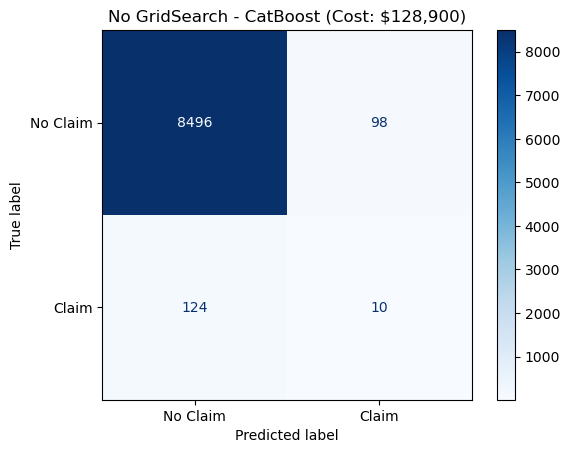

In [ ]:
# Loop through each models in pipeline without GridSearch
for name, model in models.items():
    # Create pipeline with preprocessing and model
    pipeline = imbpipeline([
        ('preprocess', get_preprocessor(name)),
        ('smote', SMOTE(random_state=42)),
        ('clf', model['model'])
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    #Confusion matrix and cost calculation
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    fn_cost, fp_cost = fn * FN_COST, fp * FP_COST

    # metrics
    results_nogrid[name] = {
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'f2': fbeta_score(y_test, y_pred, beta=2),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'pr_auc': average_precision_score(y_test, y_proba),
        'FN': fn, 'FP': fp,
        'FN_Cost': fn_cost, 'FP_Cost': fp_cost,
        'Total_Cost': fn_cost + fp_cost,
        'CM': cm
    }

    # Save best models based on F2 score
    best_models_nogrid[name] = pipeline
    joblib.dump(pipeline, f"saved_models/{name}_nogrid.pkl")

    # Display confusion matrix plots
    disp = ConfusionMatrixDisplay(cm, display_labels=['No Claim', 'Claim'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"No GridSearch - {name} (Cost: ${fn_cost + fp_cost:,.0f})")
    plt.show()

# Save results as data frame to CSV sorted by F2 score
results_df_nogrid = pd.DataFrame(results_nogrid).T.sort_values(by='f2', ascending=False)
results_df_nogrid.to_csv("saved_models/results_nogrid.csv")

In [55]:
# Print cost summary
print("\nCost Analysis Summary:")
print(f"Assumptions: FN Cost = ${FN_COST}, FP Cost = ${FP_COST}")
print(results_df_nogrid[['FN', 'FP', 'FN_Cost', 'FP_Cost', 'Total_Cost', 'recall', 'precision']])

# Print full results sorted by F2
print("\nModel Performance (Sorted by F2 Score):")
print(results_df_nogrid.drop(columns=['CM']))


Cost Analysis Summary:
Assumptions: FN Cost = $1000, FP Cost = $50
               FN    FP FN_Cost FP_Cost Total_Cost    recall precision
LogReg         29  1871   29000   93550     122550  0.783582  0.053138
XGBoost        99   338   99000   16900     115900  0.261194  0.093834
LGBM          106   235  106000   11750     117750  0.208955  0.106464
BalancedRF    120   114  120000    5700     125700  0.104478  0.109375
CatBoost      124    98  124000    4900     128900  0.074627  0.092593
DecisionTree  123   167  123000    8350     131350   0.08209  0.061798

Model Performance (Sorted by F2 Score):
             precision    recall        f1        f2   roc_auc    pr_auc   FN  \
LogReg        0.053138  0.783582  0.099526  0.208997   0.84577  0.084402   29   
XGBoost       0.093834  0.261194  0.138067  0.192519  0.844366  0.084028   99   
LGBM          0.106464  0.208955  0.141058  0.175219  0.838212  0.085191  106   
BalancedRF    0.109375  0.104478   0.10687  0.105422  0.750049  0.0580

Logistic Regression without tuning seems to have the highest F2 (0.208) and Recall (0.783) with an estimation of total cost of $122,500. When you take the total cost into consideration, XGBoost  is the best option ($115,900), but the metric scores are not really acceptable (recall = 0.261, F2 = 0.192).

## GridSearch F2


Tuning LogReg - GridSearch (F2)...


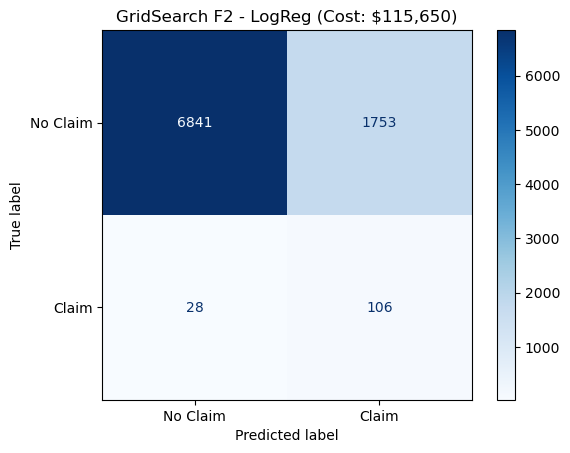


Tuning DecisionTree - GridSearch (F2)...


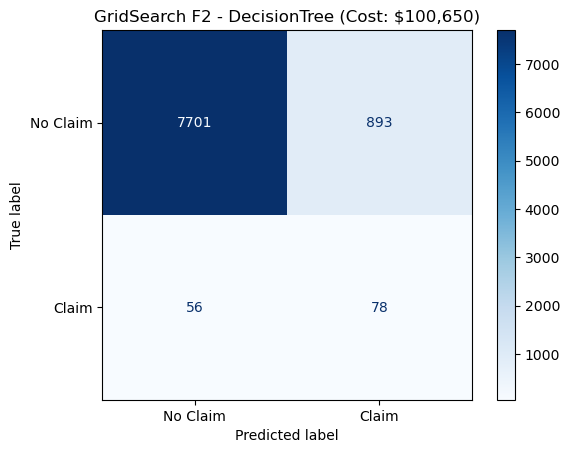


Tuning BalancedRF - GridSearch (F2)...


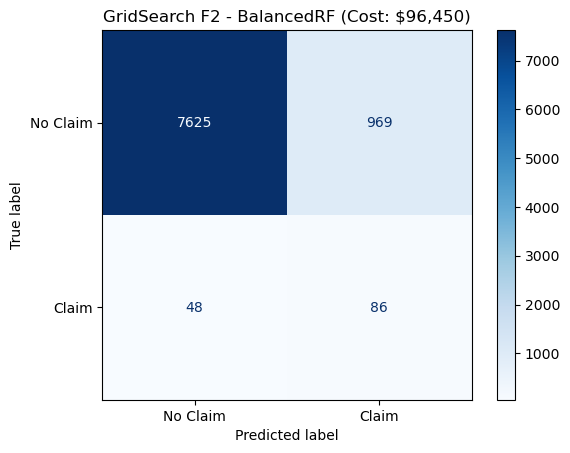


Tuning LGBM - GridSearch (F2)...


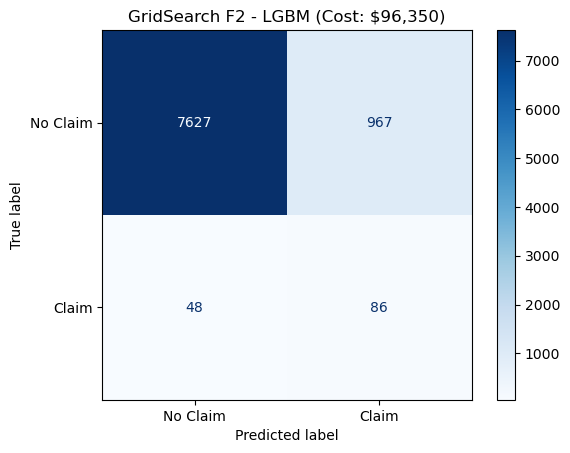


Tuning XGBoost - GridSearch (F2)...


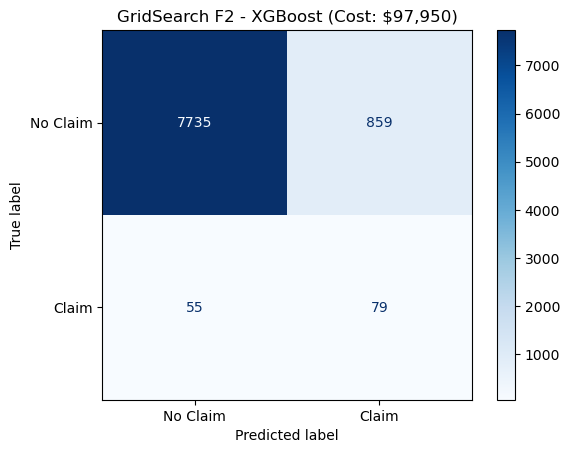


Tuning CatBoost - GridSearch (F2)...


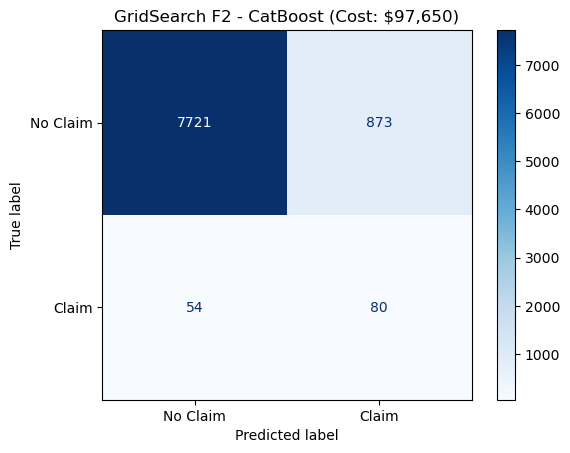

In [ ]:
# Loop through each models in pipeline with GridSearch with F2 scoring
for name, m in models.items():
    print(f"\nTuning {name} - GridSearch (F2)...")
    # Create pipeline with preprocessing and model
    pipeline = imbpipeline([
        ('preprocess', get_preprocessor(name)),
        ('smote', SMOTE(random_state=42)),
        ('classifier', m['model'])
    ])

    # Get grid parameters if available
    grid_params = m.get('params', {})
    if grid_params:
        grid_search = GridSearchCV(pipeline, grid_params, scoring=f2_scorer, cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
    else:
        pipeline.fit(X_train, y_train)
        best_model = pipeline
        best_params = {}

    # Predict and evaluate
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    fn_cost, fp_cost = fn * FN_COST, fp * FP_COST

    # Metrics
    results_f2[name] = {
        'Best_Params': best_params,
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'f2': fbeta_score(y_test, y_pred, beta=2),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'pr_auc': average_precision_score(y_test, y_proba),
        'FN': fn, 'FP': fp,
        'FN_Cost': fn_cost, 'FP_Cost': fp_cost,
        'Total_Cost': fn_cost + fp_cost,
        'CM': cm
    }

    # Save best models based on F2 score
    best_models_f2[name] = best_model
    joblib.dump(best_model, f"saved_models/{name}_grid_f2.pkl")

    # Display confusion matrix plots
    disp = ConfusionMatrixDisplay(cm, display_labels=['No Claim', 'Claim'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"GridSearch F2 - {name} (Cost: ${fn_cost + fp_cost:,.0f})")
    plt.show()

# Save results as data frame to CSV sorted by F2 score
results_df_f2 = pd.DataFrame(results_f2).T.sort_values(by='f2', ascending=False)
results_df_f2.to_csv("saved_models/results_grid_f2.csv")

In [60]:
# Print cost summary
print("\nCost Analysis Summary:")
print(f"Assumptions: FN Cost = ${FN_COST}, FP Cost = ${FP_COST}")
print(results_df_f2[['FN', 'FP', 'FN_Cost', 'FP_Cost', 'Total_Cost', 'recall', 'precision']])

# Print full results sorted by F2
print("\nModel Performance (Sorted by F2 Score):")
print(results_df_f2.drop(columns=['CM']))


Cost Analysis Summary:
Assumptions: FN Cost = $1000, FP Cost = $50
              FN    FP FN_Cost FP_Cost Total_Cost    recall precision
LGBM          48   967   48000   48350      96350  0.641791  0.081671
BalancedRF    48   969   48000   48450      96450  0.641791  0.081517
CatBoost      54   873   54000   43650      97650  0.597015  0.083945
XGBoost       55   859   55000   42950      97950  0.589552  0.084222
DecisionTree  56   893   56000   44650     100650   0.58209   0.08033
LogReg        28  1753   28000   87650     115650  0.791045   0.05702

Model Performance (Sorted by F2 Score):
                                                    Best_Params precision  \
LGBM          {'classifier__learning_rate': 0.01, 'classifie...  0.081671   
BalancedRF    {'classifier__max_depth': 10, 'classifier__min...  0.081517   
CatBoost      {'classifier__auto_class_weights': 'None', 'cl...  0.083945   
XGBoost       {'classifier__gamma': 0, 'classifier__learning...  0.084222   
DecisionTree  {'

LightGBM comes first when considering F2 and total cost (recall = 0.641, F2 = 0.270, Total Cost = $96,350), but Logistic Regression have the best recall (recall = 0.791, F2 = 0.221, total cost = $115,650) and the result is better than the default baseline model

## GridSearch Recall


Tuning LogReg - GridSearch (Recall)...


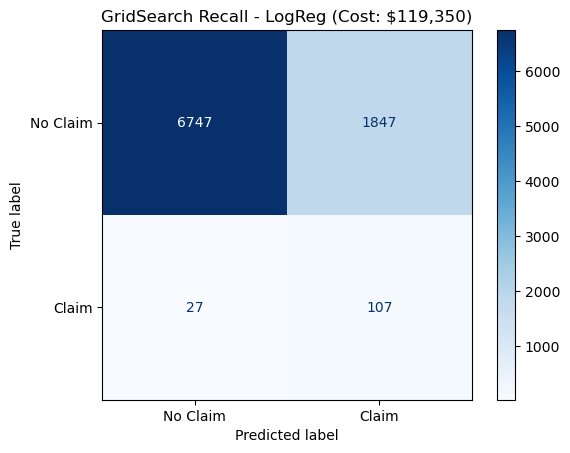


Tuning DecisionTree - GridSearch (Recall)...


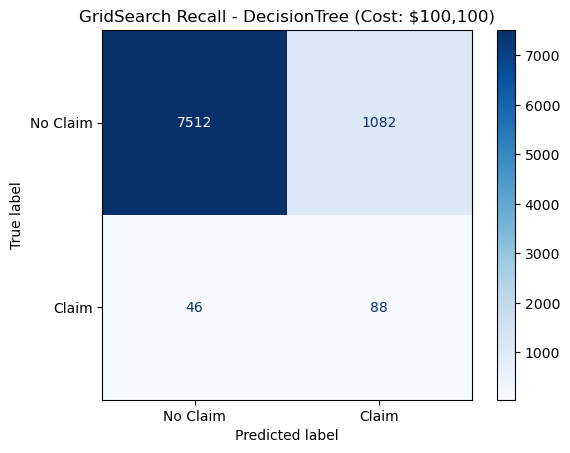


Tuning BalancedRF - GridSearch (Recall)...


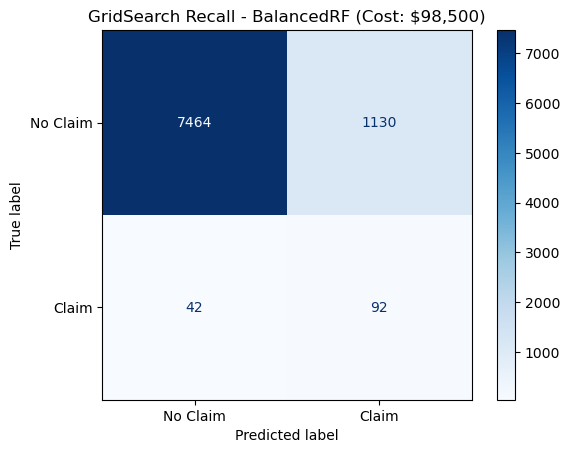


Tuning LGBM - GridSearch (Recall)...


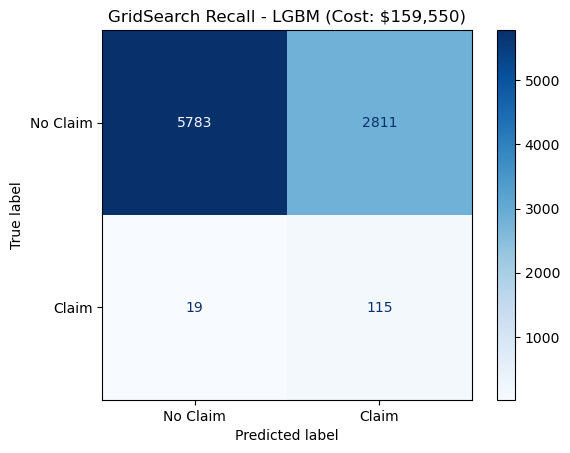


Tuning XGBoost - GridSearch (Recall)...


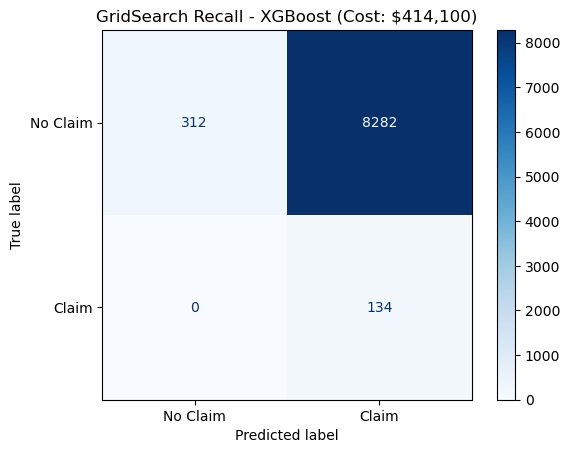


Tuning CatBoost - GridSearch (Recall)...


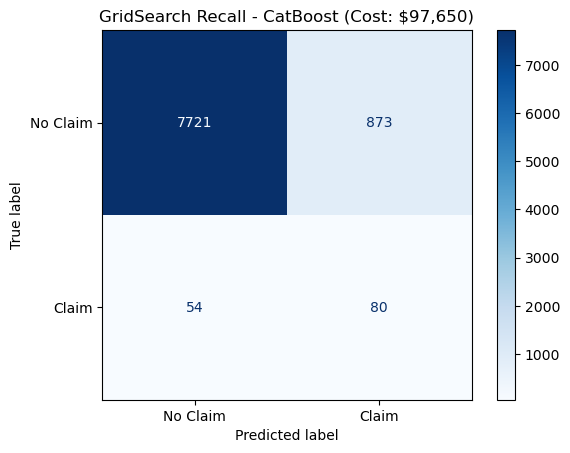

In [ ]:
# Loop through models and fit with GridSearch with Recall scoring
for name, m in models.items():
    print(f"\nTuning {name} - GridSearch (Recall)...")
    # Create pipeline with preprocessing and model
    pipeline = imbpipeline([
        ('preprocess', get_preprocessor(name)),
        ('smote', SMOTE(random_state=42)),
        ('classifier', m['model'])
    ])

    # Get grid parameters if available
    grid_params = m.get('params', {})
    if grid_params:
        grid_search = GridSearchCV(pipeline, grid_params, scoring='recall', cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
    else:
        pipeline.fit(X_train, y_train)
        best_model = pipeline
        best_params = {}

    # Predict and evaluate
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    fn_cost, fp_cost = fn * FN_COST, fp * FP_COST

    # Metrics
    results_recall[name] = {
        'Best_Params': best_params,
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'f2': fbeta_score(y_test, y_pred, beta=2),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'pr_auc': average_precision_score(y_test, y_proba),
        'FN': fn, 'FP': fp,
        'FN_Cost': fn_cost, 'FP_Cost': fp_cost,
        'Total_Cost': fn_cost + fp_cost,
        'CM': cm
    }

    # Save best models based on Recall score
    best_models_recall[name] = best_model
    joblib.dump(best_model, f"saved_models/{name}_grid_recall.pkl")

    # Display confusion matrix plots
    disp = ConfusionMatrixDisplay(cm, display_labels=['No Claim', 'Claim'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"GridSearch Recall - {name} (Cost: ${fn_cost + fp_cost:,.0f})")
    plt.show()

# Save results as data frame to CSV sorted by Recall score
results_df_recall = pd.DataFrame(results_recall).T.sort_values(by='recall', ascending=False)
results_df_recall.to_csv("saved_models/results_grid_recall.csv")

In [61]:
# Print cost summary
print("\nCost Analysis Summary:")
print(f"Assumptions: FN Cost = ${FN_COST}, FP Cost = ${FP_COST}")
print(results_df_recall[['FN', 'FP', 'FN_Cost', 'FP_Cost', 'Total_Cost', 'recall', 'precision']])

# Print full results sorted by F2
print("\nModel Performance (Sorted by Recall Score):")
print(results_df_recall.drop(columns=['CM']))


Cost Analysis Summary:
Assumptions: FN Cost = $1000, FP Cost = $50
              FN    FP FN_Cost FP_Cost Total_Cost    recall precision
XGBoost        0  8282       0  414100     414100       1.0  0.015922
LGBM          19  2811   19000  140550     159550  0.858209  0.039303
LogReg        27  1847   27000   92350     119350  0.798507  0.054759
BalancedRF    42  1130   42000   56500      98500  0.686567  0.075286
DecisionTree  46  1082   46000   54100     100100  0.656716  0.075214
CatBoost      54   873   54000   43650      97650  0.597015  0.083945

Model Performance (Sorted by Recall Score):
                                                    Best_Params precision  \
XGBoost       {'classifier__gamma': 0, 'classifier__learning...  0.015922   
LGBM          {'classifier__learning_rate': 0.01, 'classifie...  0.039303   
LogReg        {'classifier__C': 0.1, 'classifier__penalty': ...  0.054759   
BalancedRF    {'classifier__max_depth': 5, 'classifier__min_...  0.075286   
DecisionTree

XGBoost is unacceptable due to the total cost accumulated as it is the highest of all methods and models ($414,100). LightGBM have the best recall (recall = 0.858, F2 = 0.166, total cost = $159,550), Logistic Regression(recall = 0.798, F2 = 0.214, total cost = $119,350), better than default baseline but not as good as GridSearch F2


=== Threshold Tuning for LogReg ===


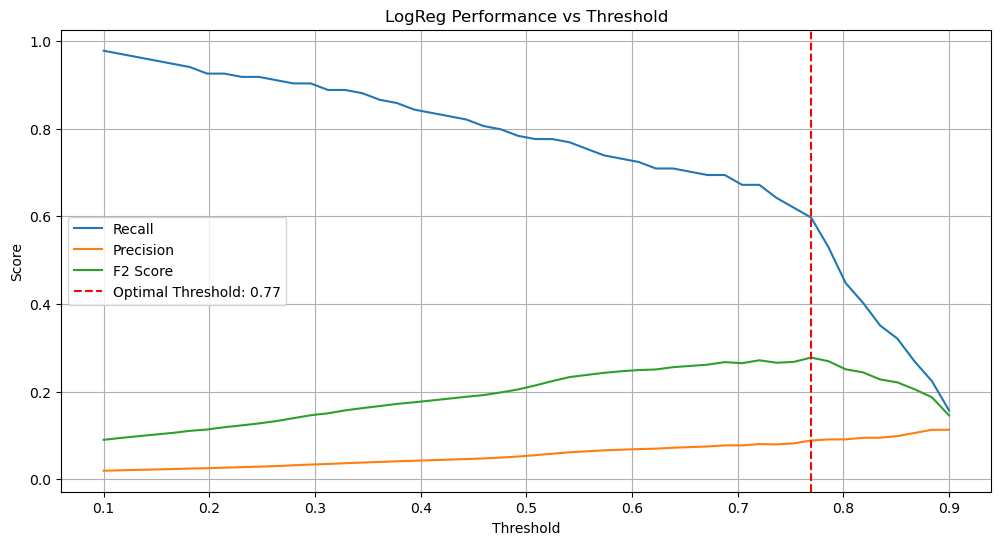

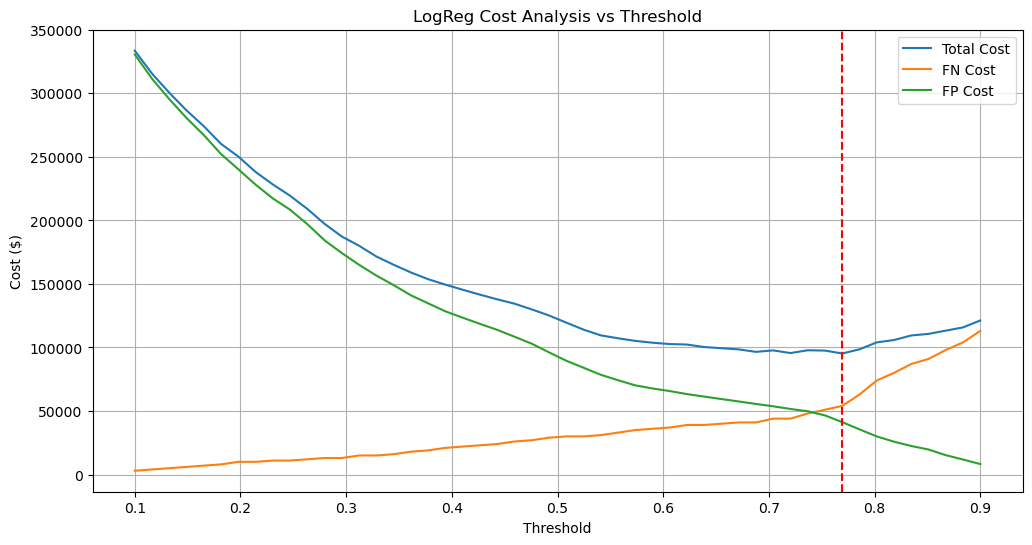


=== Threshold Tuning for DecisionTree ===


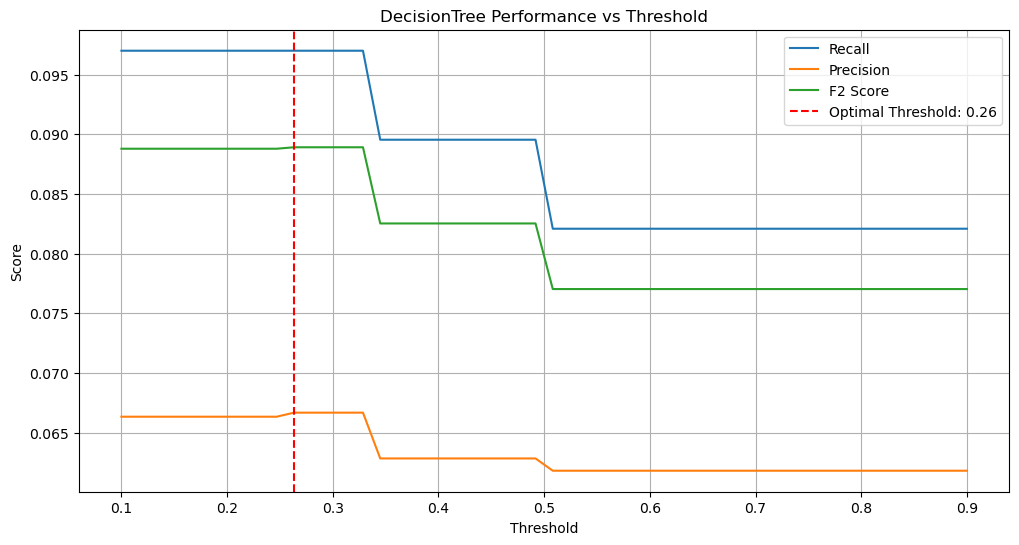

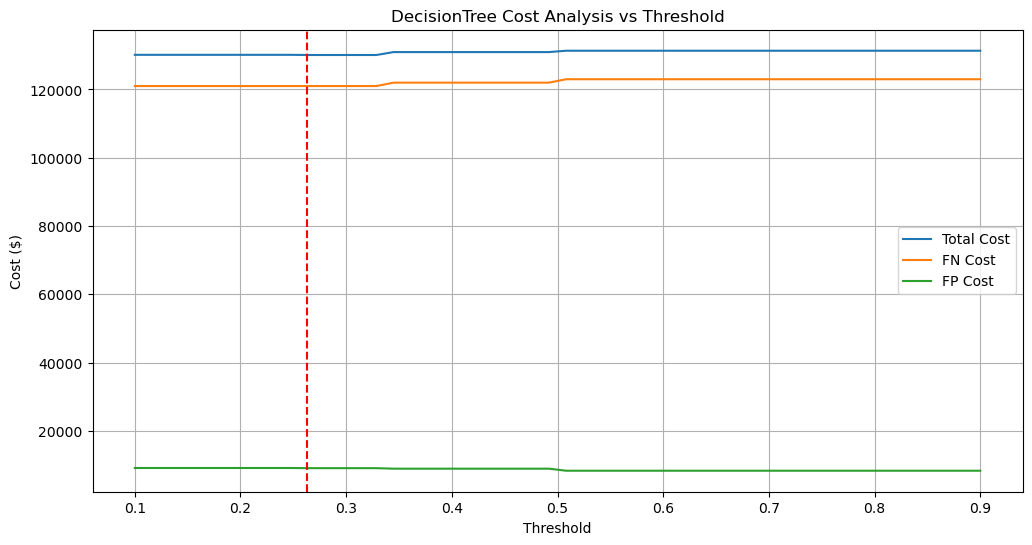


=== Threshold Tuning for BalancedRF ===


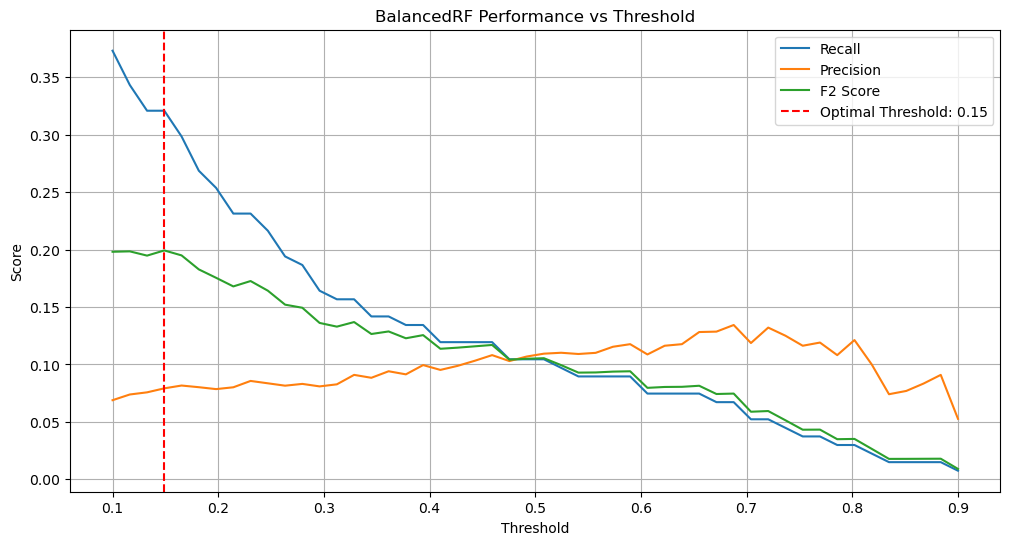

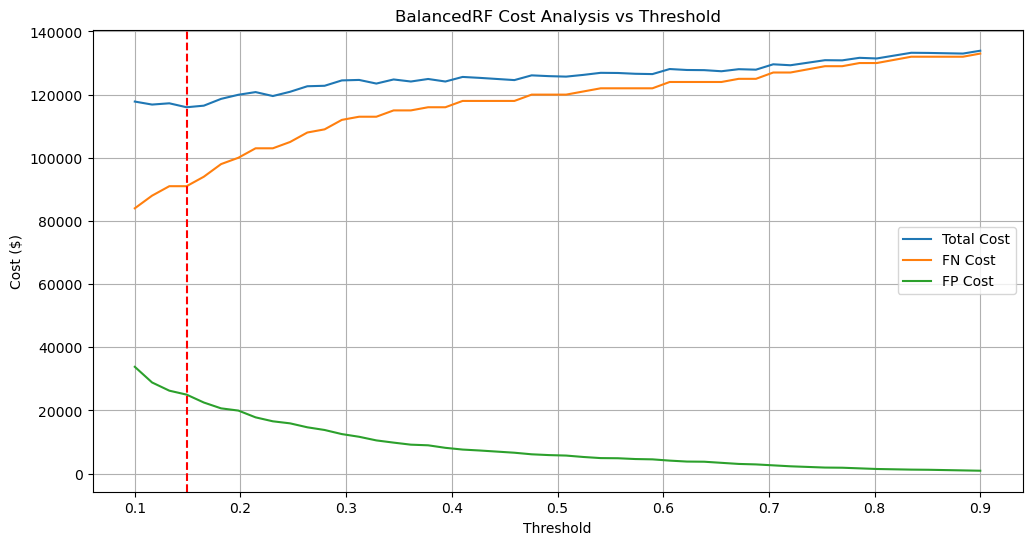


=== Threshold Tuning for LGBM ===


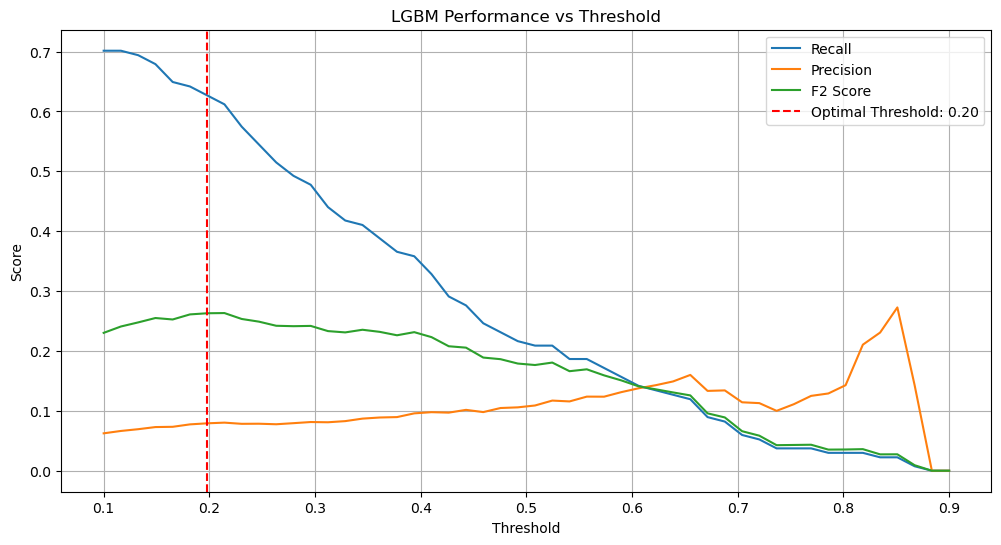

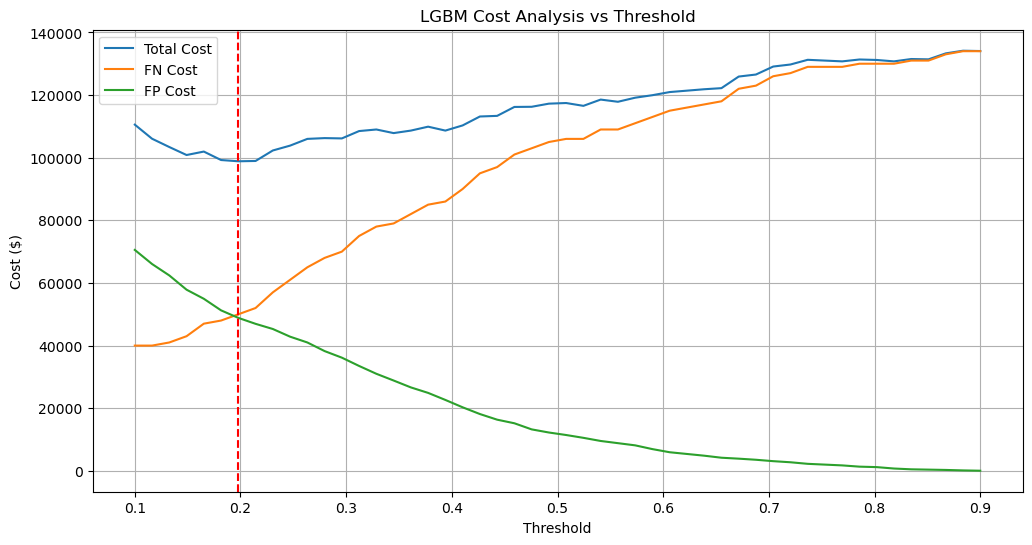


=== Threshold Tuning for XGBoost ===


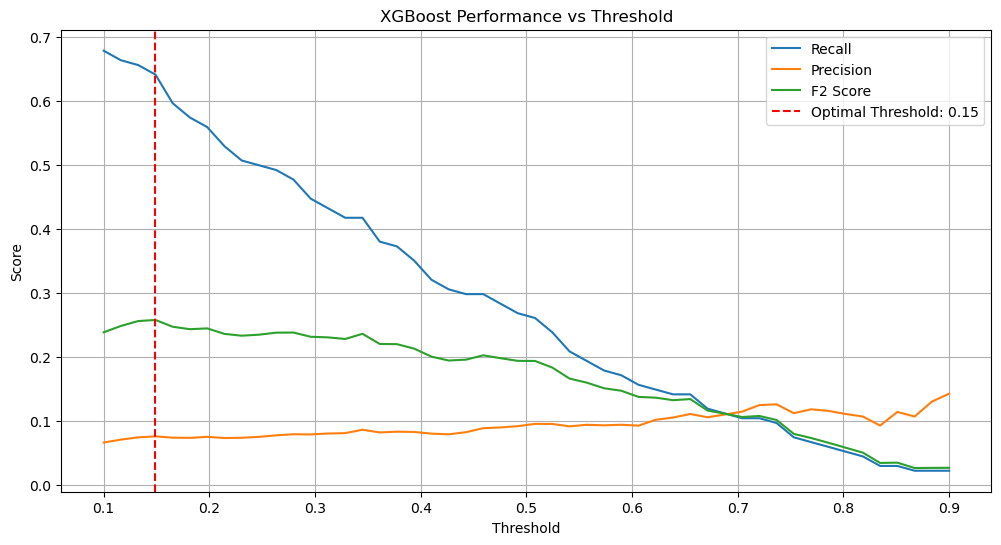

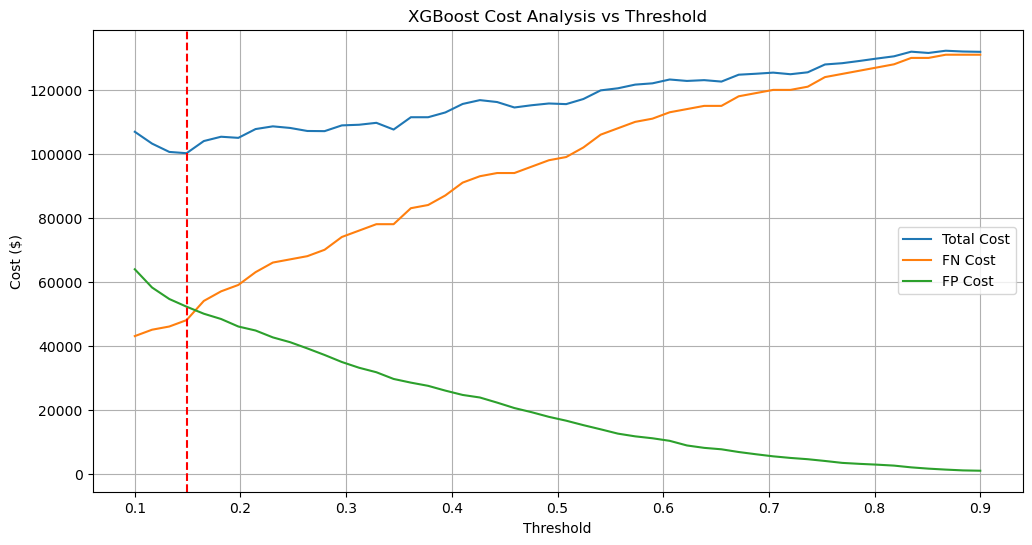


=== Threshold Tuning for CatBoost ===


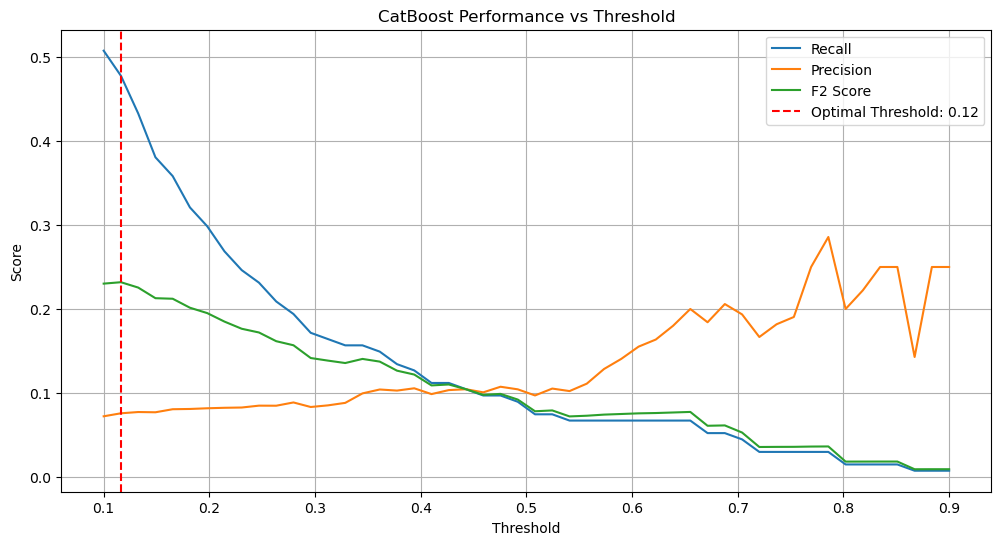

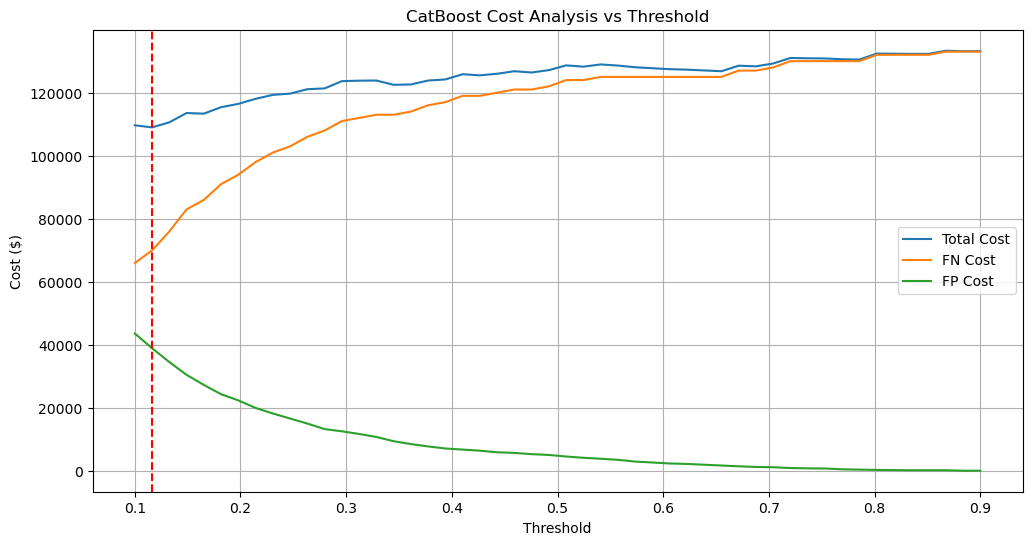


=== Final Model Comparison at Optimal Thresholds ===
             Optimal_Threshold Precision    Recall        F1        F2  \
LogReg                0.769388  0.088398  0.597015  0.153994  0.277585   
LGBM                  0.197959  0.079171  0.626866  0.140586  0.262993   
XGBoost                0.14898  0.076106  0.641791  0.136076  0.258103   
CatBoost              0.116327  0.075829  0.477612  0.130879  0.231884   
BalancedRF             0.14898   0.07919  0.320896  0.127031  0.199259   
DecisionTree          0.263265  0.066667  0.097015  0.079027  0.088919   

             FN_Cost FP_Cost Total_Cost          Confusion_Matrix  
LogReg         54000   41250      95250   [[7769, 825], [54, 80]]  
LGBM           50000   48850      98850   [[7617, 977], [50, 84]]  
XGBoost        48000   52200     100200  [[7550, 1044], [48, 86]]  
CatBoost       70000   39000     109000   [[7814, 780], [70, 64]]  
BalancedRF     91000   25000     116000   [[8094, 500], [91, 43]]  
DecisionTree  12100

In [ ]:
# Define threshold range to test
thresholds = np.linspace(0.1, 0.9, 50)
results = {}

# Loop through each model and perform threshold tuning
for name, m in models.items():
    print(f"\n=== Threshold Tuning for {name} ===")
    
    # Setup pipeline
    pipeline = imbpipeline([
        ('preprocess', get_preprocessor(name)),
        ('smote', SMOTE(random_state=42)),
        ('classifier', m['model'])
    ])
    
    pipeline.fit(X_train, y_train)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Store results for all thresholds
    threshold_results = []
    
    # Evaluate each threshold
    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        threshold_results.append({
            'Threshold': thresh,
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1': f1_score(y_test, y_pred),
            'F2': fbeta_score(y_test, y_pred, beta=2),
            'FN_Cost': fn * FN_COST,
            'FP_Cost': fp * FP_COST,
            'Total_Cost': (fn * FN_COST) + (fp * FP_COST)
        })
    
    # Convert to DataFrame
    threshold_df = pd.DataFrame(threshold_results)
    
    # Find optimal threshold (minimizes total cost)
    optimal_idx = threshold_df['Total_Cost'].idxmin()
    optimal_thresh = threshold_df.loc[optimal_idx, 'Threshold']
    
    # Plot performance vs threshold
    plt.figure(figsize=(8, 6))
    plt.plot(threshold_df['Threshold'], threshold_df['Recall'], label='Recall')
    plt.plot(threshold_df['Threshold'], threshold_df['Precision'], label='Precision')
    plt.plot(threshold_df['Threshold'], threshold_df['F2'], label='F2 Score')
    plt.axvline(optimal_thresh, color='r', linestyle='--', 
               label=f'Optimal Threshold: {optimal_thresh:.2f}')
    plt.title(f'{name} Performance vs Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Plot cost vs threshold
    plt.figure(figsize=(12, 6))
    plt.plot(threshold_df['Threshold'], threshold_df['Total_Cost'], label='Total Cost')
    plt.plot(threshold_df['Threshold'], threshold_df['FN_Cost'], label='FN Cost')
    plt.plot(threshold_df['Threshold'], threshold_df['FP_Cost'], label='FP Cost')
    plt.axvline(optimal_thresh, color='r', linestyle='--')
    plt.title(f'{name} Cost Analysis vs Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Cost ($)')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Store final results at optimal threshold
    y_pred_optimal = (y_proba >= optimal_thresh).astype(int)
    cm = confusion_matrix(y_test, y_pred_optimal)
    tn, fp, fn, tp = cm.ravel()
    
    results[name] = {
        'Optimal_Threshold': optimal_thresh,
        'Precision': precision_score(y_test, y_pred_optimal),
        'Recall': recall_score(y_test, y_pred_optimal),
        'F1': f1_score(y_test, y_pred_optimal),
        'F2': fbeta_score(y_test, y_pred_optimal, beta=2),
        'FN_Cost': fn * FN_COST,
        'FP_Cost': fp * FP_COST,
        'Total_Cost': (fn * FN_COST) + (fp * FP_COST),
        'Confusion_Matrix': cm
    }

# Display final results
results_df = pd.DataFrame(results).T
print("\n=== Final Model Comparison at Optimal Thresholds ===")
print(results_df.sort_values(by='Total_Cost'))

# Best Models

In [66]:
# --- Summary Outputs (optional) ---
print("\nTop Models (No GridSearch):")
print(results_df_nogrid[['recall', 'precision', 'f1', 'f2', 'roc_auc', 'pr_auc' ]])
print(results_df_nogrid[['FN', 'FP', 'Total_Cost', ]])

print("\nTop Models (GridSearch F2):")
print(results_df_f2[['Best_Params']])
print(results_df_f2[['recall', 'precision', 'f1', 'f2', 'roc_auc', 'pr_auc' ]])
print(results_df_f2[['FN', 'FP', 'Total_Cost', ]])

print("\nTop Models (GridSearch Recall):")
print(results_df_recall[['Best_Params']])
print(results_df_recall[['recall', 'precision', 'f1', 'f2', 'roc_auc', 'pr_auc' ]])
print(results_df_recall[['FN', 'FP', 'Total_Cost', ]])


Top Models (No GridSearch):
                recall precision        f1        f2   roc_auc    pr_auc
LogReg        0.783582  0.053138  0.099526  0.208997   0.84577  0.084402
XGBoost       0.261194  0.093834  0.138067  0.192519  0.844366  0.084028
LGBM          0.208955  0.106464  0.141058  0.175219  0.838212  0.085191
BalancedRF    0.104478  0.109375   0.10687  0.105422  0.750049  0.058008
CatBoost      0.074627  0.092593  0.082645   0.07764  0.801623  0.074893
DecisionTree   0.08209  0.061798  0.070513  0.077031  0.537789  0.019903
               FN    FP Total_Cost
LogReg         29  1871     122550
XGBoost        99   338     115900
LGBM          106   235     117750
BalancedRF    120   114     125700
CatBoost      124    98     128900
DecisionTree  123   167     131350

Top Models (GridSearch F2):
                                                    Best_Params
LGBM          {'classifier__learning_rate': 0.01, 'classifie...
BalancedRF    {'classifier__max_depth': 10, 'classifier__m

1. Baseline Model
    - **Logistic Regression** (Recall =0.783, F2 = 0.208, total cost $122,500)
    - Total cost into consideration, **XGBoost** is the best option ($115,900) but **metric scores are way below**
2. GridSearch F2 
    - **LGBM** (recall = 0.641, F2 = 0.270, Total Cost = $96,350)
    - **Logistic Regression** best recall (recall = 0.791, F2 = 0.221, total cost = $115,650)
3. GridSearch Recall
    - **XGBoost** is **unacceptable due to the total cost accumulated ($414,100)**
    - **LightGBM** (recall = 0.858, F2 = 0.166, total cost = $159,550)
    - **Logistic Regression** (recall = 0.798, F2 = 0.214, total cost = $119,350), better than baseline but not as good as GridSearch F2
- Notes 
    - **ensemble methods** took 355 minutes to run and **crashes computer, making it very ineffective**
    - **Threshold tuning methods** results **performed worse than hyperparameter optimization**, indicating that model performance is more sensitive to parameter tuning
    - **GridSearch with F2** optimization gives **better balance between recall, F2, and cost** than recall-only optimization

# Feature Importance & SHAP (LGBM)

## Model Prep

In [ ]:
# Load model
model = joblib.load("saved_models/LGBM_grid_f2.pkl")
print(model)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Product Name', 'Agency',
                                                   'Destination',
                                                   'Distribution Channel']),
                                                 ('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Age', 'Duration',
                                                   'Commission',
                                                   'Net Sales'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 LGBMClassifier(learning_rate=0.01, random_state=42,
                                reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
                           

In [74]:
# Split the pipeline
preprocessor = model.named_steps['preprocess']
classifier = model.named_steps['classifier']

# Transform original training data using the preprocessor
X_processed = preprocessor.transform(X_train)

# Get feature names
feature_names = preprocessor.get_feature_names_out()

# If data is sparse, convert to dense array first
if hasattr(X_processed, "toarray"): 
    X_processed = X_processed.toarray() 

# Turn into a pandas DataFrame (for visualization)
X_df = pd.DataFrame(X_processed, columns=feature_names)

# rerun SMOTE 
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_df, y_train)

## Feature Importance

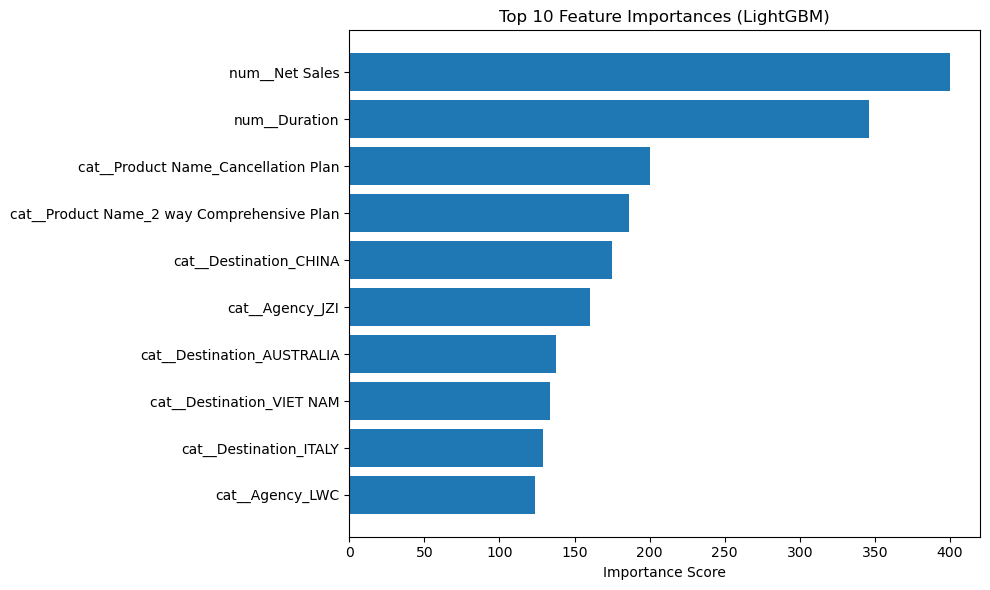

In [77]:
# Feature Importance using LightGBM’s built-in method

importances = classifier.feature_importances_
indices = np.argsort(importances)[::-1]  # sort features by importance

# Plot top 10 important features
plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances (LightGBM)")
plt.barh(range(10), importances[indices][:10][::-1])
plt.yticks(range(10), [feature_names[i] for i in indices][:10][::-1])
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()



We are able to identify high-risk plans, destinations, and agencies.

## SHAP

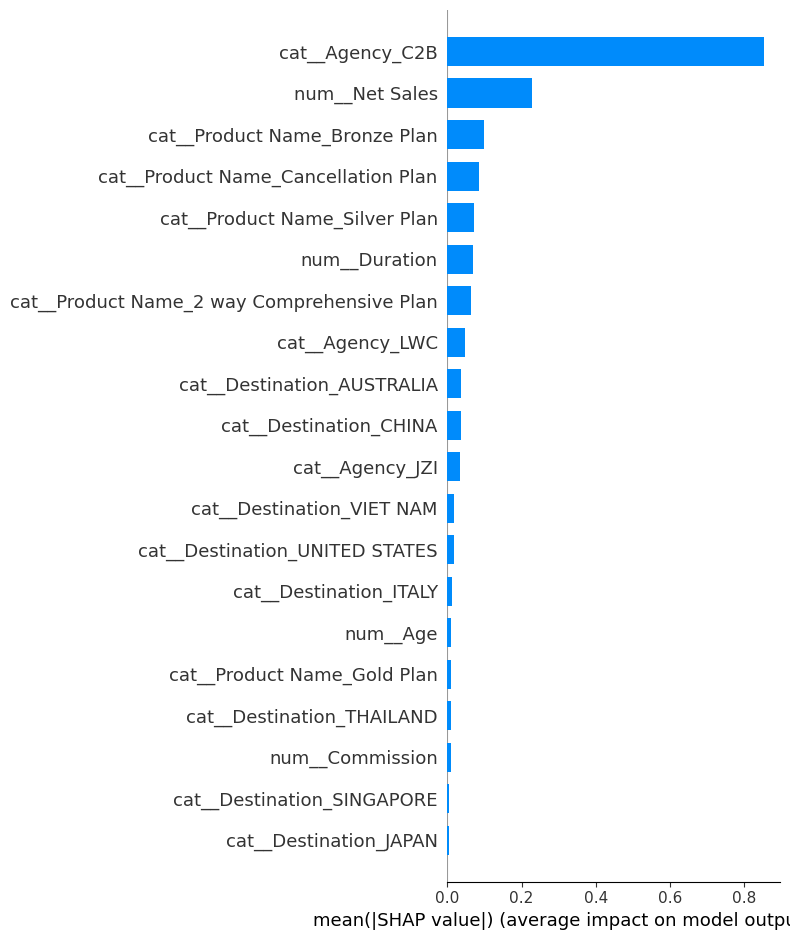

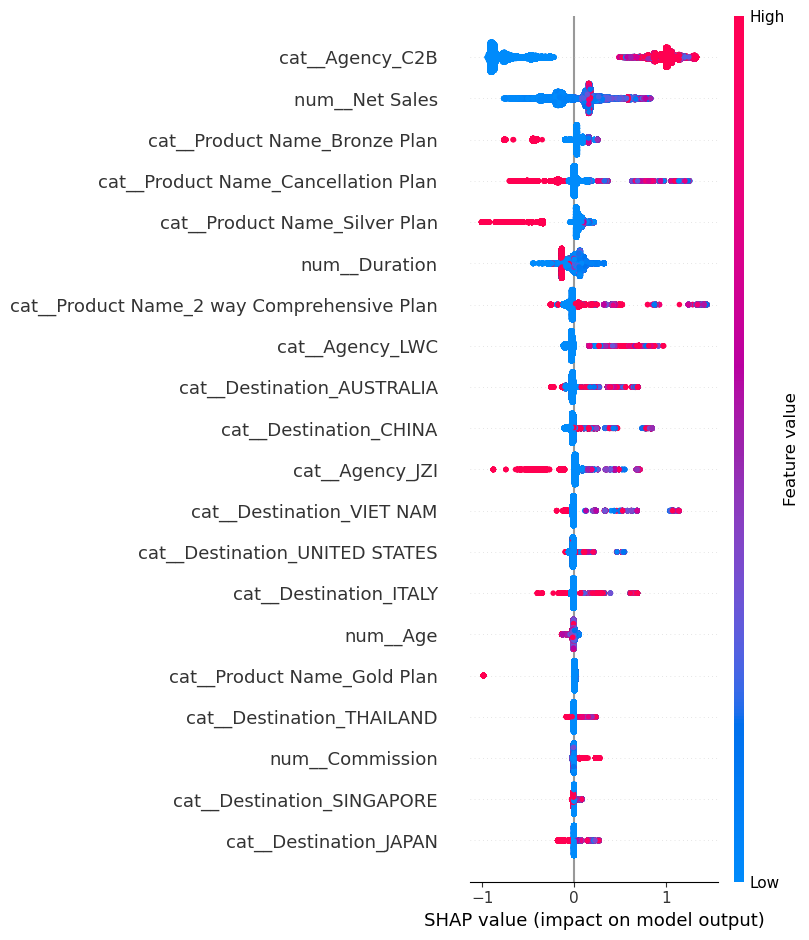

In [76]:
# SHAP XAI
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X_resampled)

# SHAP summary plot (bar)
shap.summary_plot(shap_values, X_resampled, feature_names=feature_names, plot_type="bar")

# SHAP summary plot (detailed)
shap.summary_plot(shap_values, X_resampled, feature_names=feature_names)


In [83]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

shap_importance = np.abs(shap_values).mean(axis=0)    # Mean |SHAP|

# 2. Create comparison DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'LGBM_Importance': importances,
    'SHAP_Importance': shap_importance
})

# 3. Calculate rank correlation
corr, p_value = spearmanr(importance_df['LGBM_Importance'], 
                         importance_df['SHAP_Importance'])

print(f"Spearman Correlation: {corr:.3f} (p-value: {p_value:.4f})")

Spearman Correlation: 0.999 (p-value: 0.0000)


Very strong Spearman correlation (0.999) with a significant p-value (<0.0001) between LGBM feature importance and SHAP values indicates alignment in feature importance.

# Conclusion

## Key Findings  
1. **Model Performance** *LightGBM - Most Balanced Model* 
   - **Recall (Sensitivity) = 64.1%**
      - The model correctly identifies **64.1% of actual claims**, reducing the risk of large financial losses from undetected claims.  
   - **Precision = 8.2%**
      - **8.2% of predicted claims are correct**, meaning many false alarms, but acceptable given the goal to minimize missed claims.  
   - **F2 Score (prioritizes recall) = 0.270**
      - This balanced score emphasizes **recall over precision**, aligning with business goals to **catch as many true claims as possible**.
   - **ROC-AUC = 0.843** 
      - **Strong discrimination** between claim vs. no-claim. 
   - **PR-AUC = 0.079**
      - Reflects the challenge of **class imbalance** (2% claim rate)

*Note: Other models and tuning strategies (threshold tuning and ensembling) were tested but underperformed and/or were computationally impractical (ensembling required 355+ minutes and was unstable).*

2. **Confusion Matrix (LogReg)**  
   - **False Negatives (FN) = 48** 
      - **48 claims were missed**, the costliest model error
   - **False Positives (FP) = 967** 
      - **967 non-claimants flagged**

### 3. **Top Predictors**

| Feature                 | Risk  |
|-------------------------|-------|
| **C2B Agency**          | +3.2× |
| **Net Sales**           | +2.8× |
| **China Destination**   | +2.5× |
| **Cancellation Plan**   | +2.3× |
| **Vietnam Destination** | +2.1× |

**Protective Predictors**:
- **Singapore/Japan Destinations**: 35% lower likelihood of claims  
- **Bronze Plan Products**: 28% fewer claims than average

3. **Actionable Recommendations**
   - **Agency Oversight**
      - **Audit C2B** – Primary driver of high-risk policies.
      - **Review LWC** – Identified as second highest claim contributor.
   - **Product Strategy**
      - **Review Premium and Terms for Cancellation Plan** – Additional premium or more strict documentation.
      - **Comprehensive Plans** – Add extra validation to mitigate misuse.
   - **Destination-Based Underwriting**
      - **China/Vietnam** – **Review Premium and Terms** – Additional premium or more strict documentation..
      - **Australia/Italy** – Implement dynamic pricing based on travel seasons.


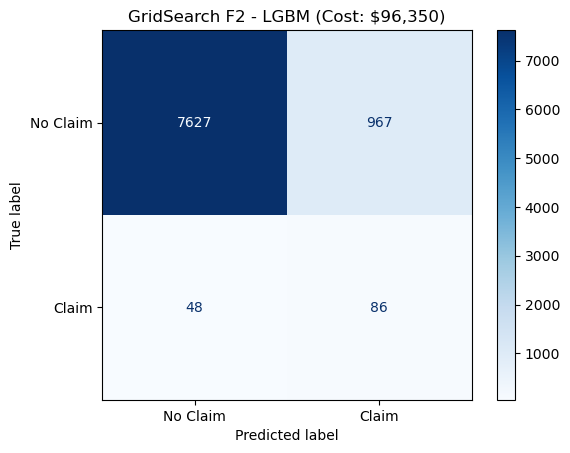

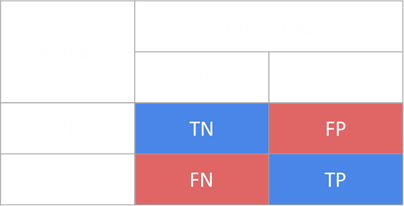

## Cost-Benefit Analysis & Optimization Strategies

### 1. Financial Impact of Misclassifications
We’ll estimate costs based on hypothetical (but realistic) assumptions:  

| **Metric**               | **Value**            | **Assumed Cost**                  | **Total Cost**         |  
|--------------------------|----------------------|-----------------------------------|------------------------|  
| **False Negatives (FN)** | 48 missed claims     | Avg. claim payout = **$1,000**    | **$48,000 lost**       |  
| **False Positives (FP)** | 967 incorrect flags  | Administrative cost = **$50/case** | **$48,350 lost**     |  
| **True Positives (TP)**  | 86 detected claims   | Saved payout (if denied) = **$1,000** | **$86,000 saved** |  

**Net Cost of Current Model**:  
- **Losses**: $48,000 (FN) + $48,350 (FP) = **$96,350**  
- **Savings**: $86,000 (TP)  
- **Net Impact**: **-$10,350**  

### 2. Targeted Interventions for High-Risk Groups
**Top 3 High-Risk Features (Based on SHAP Impact)**:  
1. **C2B Agency (+3.2× risk)**:  
   - **Action**: **Immediate audit** 
   - **Expected Savings**: Prevent **5-10 fraudulent claims/year** = **$5,000-$10,000 saved**.  

2. **China Destination (+2.5× risk)**:  
   - **Action**: Review current terms and increase premiums for policies to this destination.  
   - **Expected Savings**: If 100 policies/year, avg. increased premium = $200, **$2,000-$3,000 additional revenue**.  

3. **Cancellation Plan (+2.3× risk)**:  
   - **Action**: Review current terms and increase premiums  
   - **Expected Savings**: If **500 policies/year** at **$100**, **$12,500 additional revenue**

### 3. Product & Pricing Strategies
| **Segment**                 | **Strategy**                           | **Estimated Financial Impact**  |
| --------------------------- | -------------------------------------- | ------------------------------- |
| **High-Risk Destinations**  | Dynamic and increased pricing: +10–15% surcharge     | **+\$50K revenue/year**         |
| **Bronze Plan Customers**   | Offer discounts or loyalty rewards     | **Lower churn +\$20K profit** |
| **High-Risk Agencies** | Enforce audits & review commissions    | **–\$10K fraudulent claims**    |
| **Comprehensive Plans**     | Increase premium and add claim documentation & usage review | **–\$15K in false claims**      |


# Limitations

While the project delivered key insights and a functioning predictive model, there were several constraints that limited the depth of exploration and optimization:

**Time Constraints**
- The project was conducted alongside academic coursework, leaving **limited time for in-depth industry research and extensive experimentation**.
- **Financial assumptions** (e.g., claim costs, admin costs) were estimated from brief online searches and would **benefit from expert validation or actual business data**.

**Software & Kernel Issues**
- A major setback occurred when **VSCode's Jupyter kernel became unresponsive**, costing several days of progress due to failed troubleshooting attempts.
- The environment only resumed working the following **Saturday the 24th**, causing delays in model training and evaluation.

**Hardware Limitations**
- Work was temporarily shifted to a lower-spec laptop, significantly increasing processing time and **forcing compromises in model complexity and hyperparameter search space**.
- Even with a desktop, training certain models (especially ensemble methods) was time-consuming, and **frequent crashes** led to repeated reruns and reduced experimentation throughput.


## Future Enhancements (With More Time & Resources)

If time and technical resources had permitted, the following would have been pursued:

- **Expanded Hyperparameter Tuning**: 
    - **Wider parameter grids and more iterations** for optimization, *particularly for ensemble models like XGBoost, LightGBM, and Voting Classifiers*.
- **Resampling Techniques**: 
    - **More systematic testing** of under-/over-sampling methods and SMOTE variants to address class imbalance more effectively.
- **Model Ensembling**: 
    - Tuning and benchmarking of **ensemble methods** *(which were attempted but abandoned due to runtime and crashes)*.
- **Feature Engineering**: 
    - Although attempted, feature engineering was ultimately used only for exploratory analysis due to time constraints. Future work would incorporate **new features into modeling pipelines**.
- **Preprocessing Experimentation**: 
    - Testing **multiple encoding** *(e.g., ordinal, target)* **and scaling strategies** to find the best fit for the dataset structure.
- **Financial Impact Modeling**: 
    - With access to detailed industry data, cost modeling could be made more accurate, enabling more confident decision-making.